## Multi-threading case

In [7]:
!pip3 install selenium==4.6.0
!pip3 install webdriver-manager==3.8.5
!pip3 install diagrams==0.23.1
!pip3 install retry==0.9.2
!pip3 install loguru==0.6.0

In [8]:
import os
import threading
import time

from selenium import webdriver
from selenium.webdriver.common.by import By

from webdriver_manager.chrome import ChromeDriverManager
from webdriver_manager.core.utils import ChromeType
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service

from IPython import display
from IPython.display import Image
from base64 import b64decode, urlsafe_b64decode, decodebytes

from retry import retry
from loguru import logger
from timeit import default_timer as timer
from datetime import timedelta

In [3]:
def saveBase64Image(img_data, filename):
    with open(f"src/{filename}", "wb") as fh:
        fh.write(b64decode(img_data))

In [9]:
logger.add("file_{time}.log", level='DEBUG')

1

In [16]:
chrome_service = Service(ChromeDriverManager().install())
logger.info("Install chrome driver")

[WDM] - Downloading: 100%|█████████████████| 8.61M/8.61M [00:00<00:00, 28.5MB/s]
2022-12-24 10:10:13.697 | INFO     | __main__:<module>:2 - Install chrome driver


In [17]:
# Get environment variables
IS_GITHUB_ACTION = os.getenv('IS_GITHUB_ACTION')
logger.info("Set github action env")

2022-12-24 10:10:15.319 | INFO     | __main__:<module>:3 - Set github action env


In [7]:
chrome_options = Options()
if IS_GITHUB_ACTION:
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)

logger.info("Set chrome driver options")

2022-12-18 00:00:08.407 | INFO     | __main__:<module>:17 - Set chrome driver options


In [8]:
logger.info("Run chrome driver")
browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
browser.set_window_size(1920, 1080)
browser.get('https://www.gotokyo.org/kr/destinations/index.html')
logger.debug("Load main page done url {url}", url='https://www.gotokyo.org/kr/destinations/index.html')

2022-12-18 00:00:08.414 | INFO     | __main__:<module>:1 - Run chrome driver
2022-12-18 00:00:19.118 | DEBUG    | __main__:<module>:5 - Load main page done url https://www.gotokyo.org/kr/destinations/index.html


2022-12-18 00:00:19.126 | INFO     | __main__:<module>:1 - Crawl place list
2022-12-18 00:00:19.149 | DEBUG    | __main__:<module>:3 - Place list len: 9


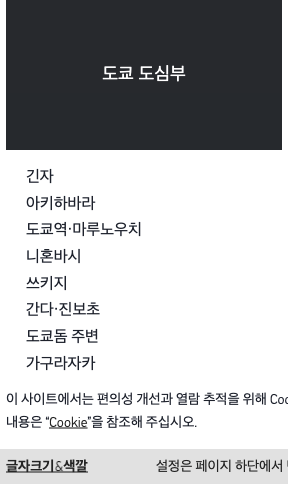

In [9]:
logger.info("Crawl place list")
placeList = browser.find_elements(By.CSS_SELECTOR, '#tmp_explore_tokyo > div > ul.mod_figure_list > li');
logger.debug("Place list len: {place_len}", place_len = len(placeList))
display.Image(b64decode(placeList[0].screenshot_as_base64))

# saveBase64Image(placeList[0].screenshot_as_base64, "test.png")

In [10]:
def getAreaListFromPlace(place):
    try:
        return [(area.text, area.get_attribute("href")) for area in place.find_elements(By.CSS_SELECTOR, "a + ul > li > a")]
    except Exception as e:
        logger.error("Cannot get place data, e: {err}", place=place, err=e)
    return []


In [11]:
logger.info("Crawl place's area data")
placeAndUrlList = [(place.find_element(By.TAG_NAME, 'a').text, 
                    place.find_element(By.TAG_NAME, 'a').get_attribute('href'),
                    getAreaListFromPlace(place)
                   ) for place in placeList]
logger.debug("Place's area data: {data}", data=placeAndUrlList)
# placeAndUrlList

2022-12-18 00:00:19.325 | INFO     | __main__:<module>:1 - Crawl place's area data
2022-12-18 00:00:20.994 | DEBUG    | __main__:<module>:6 - Place's area data: [('도쿄 도심부', 'https://www.gotokyo.org/kr/destinations/central-tokyo/index.html', [('긴자', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html'), ('아키하바라', 'https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html'), ('도쿄역・마루노우치', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html'), ('니혼바시', 'https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html'), ('쓰키지', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html'), ('간다・진보초', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/index.html'), ('도쿄돔 주변', 'https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-dome-and-around/index.html'), ('가구라자카', 'https://www.gotokyo.org/kr/destinations/central-tokyo/kagurazaka/index.html'), ('아카사카', '

In [12]:
logger.info("Close place crawling browser")
browser.close()

2022-12-18 00:00:21.000 | INFO     | __main__:<module>:1 - Close place crawling browser


## Get area's detail info

In [13]:
def getSlideItems(slideItemList):
    logger.debug("Slider item list len {}", len(slideItemList))
    try:
        return [{
            'contentName': slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'),
            'contentImg': slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'),
            'contentDetailURL': slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href')
        } for slideItem in slideItemList]
#     [(slideItem.find_element(By.TAG_NAME, 'img').get_attribute('alt'), # tour content name
#             slideItem.find_element(By.TAG_NAME, 'img').get_attribute('src'), # tour content img
#             slideItem.find_element(By.TAG_NAME, 'a').get_attribute('href') # tour content detail link
#             ) for slideItem in slideItemList]
    except Exception as e:
        logger.error("Slider item error {}", e)

In [29]:
@retry(Exception, tries=3, delay=4)
def getSlideList(browser):
    sliderCrawlResult = []
    try:
        logger.info("Remove banner to load slider list")
        browser.execute_script("document.querySelector('div.section_banner_top').remove();document.querySelector('div.left_block').remove();jQuery(window).scroll();")
        logger.info("Banner removed")
    except Exception as e:
        logger.error("Remove banner has an error {}", e)
    logger.info("Crawl slider items")
    sliderCrawlResult = [{
            'silderTitle': slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text,
            'silderItems': getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]),
        } for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
#     [(
#         slider.find_element(By.CSS_SELECTOR, 'div.slider_ttl > h2').text, #title
#         getSlideItems([item for item in slider.find_elements(By.CSS_SELECTOR, 'div.slick_slide_item')]) #slider's items
#         ) for slider in browser.find_elements(By.CSS_SELECTOR, 'div.section_slider_body')]
    logger.debug("Crawl slider items result {}", sliderCrawlResult)
    if sum([len(sliderItemList['silderItems']) for sliderItemList in sliderCrawlResult]) <= 0:
        logger.info("Slider is empty, raise error");
        raise Exception('Data not found')
    return sliderCrawlResult
    
# getSlideList(browser)

In [12]:
@retry(Exception, tries=3, delay=2)
def initHeadlessBrowser():
    logger.info("Setup headless browser options")
    chrome_options = Options()
    options = [
        "--headless",
        "--disable-gpu",
        "--window-size=1920,1080",
        "--ignore-certificate-errors",
        "--disable-extensions",
        "--no-sandbox",
        "--disable-dev-shm-usage",
        "--enable-automation",
        "start-maximized",
        "disable-infobars"
    ]
    user_agent = 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36'    
    chrome_options.add_argument('user-agent={0}'.format(user_agent))
    for option in options:
        chrome_options.add_argument(option)
    browser = webdriver.Chrome(service=chrome_service, options=chrome_options)
    browser.set_window_size(1920, 1080)
    return browser

In [16]:
def resizeBrowserHeightAsContentFullHeight(browser):
    logger.info("Update browser's height same as content height")
    requireHeight = browser.execute_script('return document.body.parentNode.scrollHeight')
    logger.debug("Current content height {}", requireHeight)
    browser.set_window_size(1920, requireHeight)
    browser.execute_script("document.querySelector('div.section_banner_top.setheight').style.height = '464px';")
    logger.info("Manually set banner's height")
    time.sleep(2) # Because of pictures load time

In [21]:
def getAreaInfoProcess(areaName, url, queue=None, idx=None):
    logger.debug("Area crawling process start, url: {}", url)
    slidItemList = []
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        resizeBrowserHeightAsContentFullHeight(browser)
        saveBase64Image(browser.find_element(By.CSS_SELECTOR, "div.left_block").screenshot_as_base64, f'{areaName}.png')
        slidItemList = getSlideList(browser)
        logger.info("Get slider item done")
        if queue is not None:
            queue.put({
                'idx': idx, 
                'slidItemList': slidItemList
            })
    except Exception as e:
        logger.error('Cannot get area info data {}', e)
    finally:
        browser.close()
    logger.info("Area crawling browser closed")
    return slidItemList

In [32]:
start = timer()
getAreaInfoProcess('ginza', 'https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html')
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-17 23:48:05.906 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-17 23:48:05.908 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-17 23:48:06.918 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-17 23:48:15.908 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-17 23:48:15.922 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 5734
2022-12-17 23:48:16.031 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7 - Manually set banner's height
2022-12-17 23:48:19.175 | INFO     | __main__:getSlideList:5 - Remove banner to load slider list
2022-12-17 23:48:19.189 | INFO     | __main__:getSlideList:7 - Banner removed
2022-12-17 23:48:1

## Single thread, Single process

In [43]:
start = timer()
areaCrawlingResult = []
for place in placeAndUrlList:
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        areaCrawlingResult.append(getAreaInfoProcess(area[0], area[1]))
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 10:37:38.962 | DEBUG    | __main__:<module>:4 - place: 도쿄 도심부 len: 11
2022-12-11 10:37:38.964 | DEBUG    | __main__:<module>:6 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:38.965 | DEBUG    | __main__:getAreaInfoProcess:2 - Area crawling process start, url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:38.966 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-11 10:37:39.500 | DEBUG    | __main__:getAreaInfoProcess:6 - Browser move to url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-11 10:37:41.919 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:2 - Update browser's height same as content height
2022-12-11 10:37:41.928 | DEBUG    | __main__:resizeBrowserHeightAsContentFullHeight:4 - Current content height 7829
2022-12-11 10:37:42.039 | INFO     | __main__:resizeBrowserHeightAsContentFullHeight:7

MaxRetryError: HTTPConnectionPool(host='localhost', port=51125): Max retries exceeded with url: /session/9652fd5301d511bd6ab932668111ee7b/window (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7faab0046880>: Failed to establish a new connection: [Errno 61] Connection refused'))

```
2022-12-10 22:26:21.084 | DEBUG    | __main__:<module>:9 - Process take time 0:12:11.764783
```

In [ ]:
areaCrawlingResult

In [ ]:
areaCrawlingResult[0][0]

## Single process, Multi-threading

In [22]:
from queue import Queue

In [30]:
start = timer()
areaCrawlingResult = []
queue = Queue()
idx = 0
for place in placeAndUrlList:
    threadList = []
    logger.debug("place: {} len: {}", place[0], len(place[2]))
    for area in place[2]:
        logger.debug("area: {} url: {}", area[0], area[1])
        threadList.append(threading.Thread(target=getAreaInfoProcess, args=[area[0], area[1], queue, idx]))
        idx += 1
        
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]
    
    while not queue.empty():
        areaCrawlingResult.append(queue.get())
    time.sleep(2)

end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-18 00:26:25.566 | DEBUG    | __main__:<module>:7 - place: 도쿄 도심부 len: 11
2022-12-18 00:26:25.567 | DEBUG    | __main__:<module>:9 - area: 긴자 url: https://www.gotokyo.org/kr/destinations/central-tokyo/ginza/index.html
2022-12-18 00:26:25.568 | DEBUG    | __main__:<module>:9 - area: 아키하바라 url: https://www.gotokyo.org/kr/destinations/central-tokyo/akihabara/index.html
2022-12-18 00:26:25.569 | DEBUG    | __main__:<module>:9 - area: 도쿄역・마루노우치 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tokyo-station-and-marunouchi/index.html
2022-12-18 00:26:25.570 | DEBUG    | __main__:<module>:9 - area: 니혼바시 url: https://www.gotokyo.org/kr/destinations/central-tokyo/nihombashi/index.html
2022-12-18 00:26:25.571 | DEBUG    | __main__:<module>:9 - area: 쓰키지 url: https://www.gotokyo.org/kr/destinations/central-tokyo/tsukiji/index.html
2022-12-18 00:26:25.572 | DEBUG    | __main__:<module>:9 - area: 간다・진보초 url: https://www.gotokyo.org/kr/destinations/central-tokyo/kanda-and-jimbocho/in

```
2022-12-10 22:51:23.946 | DEBUG    | __main__:<module>:14 - Process take time 0:02:17.029693
```

In [31]:
areaCrawlingResult

[{'idx': 5,
  'slidItemList': [{'silderTitle': '종교적인 장소',
    'silderItems': [{'contentName': '야스쿠니 신사',
      'contentImg': 'https://www.gotokyo.org/kr/spot/466/images/5653_1_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/466/index.html'},
     {'contentName': '간다묘진 신사',
      'contentImg': 'https://www.gotokyo.org/kr/spot/17/images/17_0093_4_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/17/index.html'},
     {'contentName': '가톨릭 간다 교회',
      'contentImg': 'https://www.gotokyo.org/kr/spot/97/images/97_3_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/97/index.html'}]},
   {'silderTitle': '아트・박물관',
    'silderItems': [{'contentName': '메이지대학 현대 만화 도서관',
      'contentImg': 'https://www.gotokyo.org/en/spot/323/images/323_670x450.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/323/index.html'},
     {'contentName': '쇼케이관 전쟁 상병자 사료관',
      'contentImg': 'https://www.gotokyo.org/kr/spot/11

In [53]:
areaCrawlingResult = sorted(areaCrawlingResult, key=lambda d: d['idx']) 
areaCrawlingResult

[{'idx': 0,
  'slidItemList': [{'silderTitle': '아트・디자인',
    'silderItems': [{'contentName': '뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티',
      'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/221003/images/221003_main_400.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html'},
     {'contentName': '음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소',
      'contentImg': 'https://www.gotokyo.org/en/new-and-now/new-and-trending/190311/images/190311_thum_400.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/new-and-now/new-and-trending/190311/topics.html'},
     {'contentName': '긴자 그래픽 갤러리',
      'contentImg': 'https://www.gotokyo.org/kr/spot/186/images/4447_1_670x450_1.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/kr/spot/186/index.html'},
     {'contentName': 'GINZA PLACE(긴자 플레이스)',
      'contentImg': 'https://www.gotokyo.org/en/spot/665/images/665_0433_1_670x450.jpg',
      'contentDetailURL': 'https://www.gotokyo.org/

In [54]:
import json
with open("areaCrawlingResult.json", 'w') as outfile:
    json.dump(areaCrawlingResult, outfile)
    
with open("placeAndUrlList.json", 'w') as outfile:
    json.dump(placeAndUrlList, outfile)

In [28]:
import matplotlib.pyplot as plt 

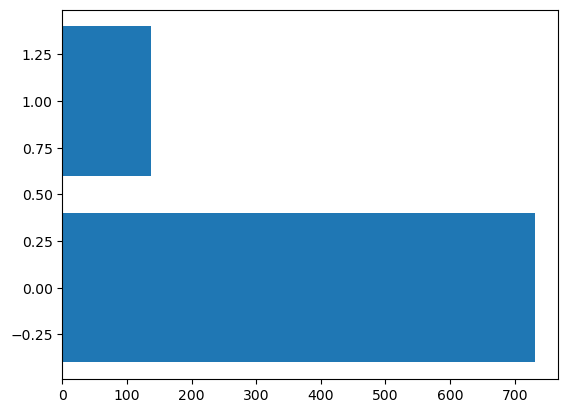

In [29]:
data2 = [12 * 60 + 11, 2 * 60 + 17]

plt.barh(range(len(data2)), data2)

plt.show() 

## Crawl content detail

```
a = {
    key: value
}

a[key] 
```

- https://youtu.be/KyUTuwz_b7Q

- https://ko.wikipedia.org/wiki/%ED%95%B4%EC%8B%9C_%ED%95%A8%EC%88%98

In [88]:
df.get('content-url')[0]

'https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html'

In [18]:
browser = initHeadlessBrowser()
browser.get(df.get('content-url')[0])

2022-12-24 10:10:25.653 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options


In [19]:
def getTableData(browser):
    tableList = browser.find_elements(By.CSS_SELECTOR, 'div.left_block > table')
    tableResult = []
    for table in tableList:
        for tr in table.find_elements(By.TAG_NAME, 'tr'):
            head = tr.find_element(By.TAG_NAME, 'th').text
            data = tr.find_element(By.TAG_NAME, 'td').text
            url = ''
            if head == 'URL':
                url = tr.find_element(By.CSS_SELECTOR, 'td > a').get_attribute('href')
            tableResult.append({
                'head': head,
                'data': data + '|' + url
            })
    return tableResult

In [20]:
getTableData(browser)

[{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플라자 긴자 6F|'},
 {'head': 'URL', 'data': '즈칸 뮤지엄 긴자(ENG)|https://zukan-museum.com/en/'},
 {'head': '주소', 'data': '도쿄도 미나토구 다이바 1-6-1 덱스 도쿄 비치 씨사이드 몰 4F|'},
 {'head': 'URL',
  'data': '도쿄 트릭아트 미궁관(ENG)|https://www.trickart.info/english/index.html'},
 {'head': '주소', 'data': '도쿄도 미나토구 아카사카 5-3-6|'},
 {'head': 'URL',
  'data': '해리 포터를 형상화한 아카사카 사카스의 거리 풍경(JPN)|https://innovation.tbs.co.jp/?world=worldport'}]

In [21]:
def getOpenHours(browser):
    open_hours = browser.find_element(By.CSS_SELECTOR, 'div.opening_hours')
    scheduleList = open_hours.find_elements(By.CSS_SELECTOR, 'li.opening_hours_item')
    return [schedule.text for schedule in scheduleList]

In [22]:
def getPriceInfo(browser):
    price_info = browser.find_element(By.CSS_SELECTOR, 'div.price_info')
    return price_info.text

In [23]:
def getFacilityInfo(browser):
    facilityResult = []
    facility_info = browser.find_element(By.CSS_SELECTOR, 'div.facility_info')
    facilityList = facility_info.find_elements(By.CSS_SELECTOR, 'ul.facility_info_list')
    for facility in facilityList:
        for info in facility.find_elements(By.TAG_NAME, 'li'):
            facilityResult.append(info.text)
    return facilityResult

In [24]:
def getCovidInfo(browser):
    covidInfoList = []
    covid_info = browser.find_element(By.CSS_SELECTOR, 'div.countermeasure_info')
    for info in covid_info.find_elements(By.TAG_NAME, 'li'):
        covidInfoList.append(info.text)
        try:
            covidInfoList.append(info.find_element(By.TAG_NAME, 'a').get_attribute('href'))
        except:
            print()
    return covidInfoList

In [25]:
browser.close()

In [112]:
def getContentDetail(url):
    result = {
        'tableData': [],
        'openHourData': [],
        'priceData': None,
        'facilityInfo': [],
        'covidInfo': []
    }
    try:
        browser = initHeadlessBrowser()
        logger.debug("Browser move to url: {}", url)
        browser.get(url)
        try:
            result['tableData'] = getTableData(browser)
        except Exception as e:
            logger.error('Cannot get table data {}', e)
        try:
            result['openHourData'] = getOpenHours(browser)
        except Exception as e:
            logger.error('Cannot get open hour data {}', e)
        try:
            result['priceData'] = getPriceInfo(browser)
        except Exception as e:
            logger.error('Cannot get price data {}', e)
        try:
            result['facilityInfo'] = getFacilityInfo(browser)
        except Exception as e:
            logger.error('Cannot get facility data {}', e)
        try:
            result['covidInfo'] = getCovidInfo(browser)
        except Exception as e:
            logger.error('Cannot get covid data {}', e)
    except Exception as e:
        logger.error('Cannot get content detail {}', e)
    finally:
        browser.close()
    return result

In [113]:
getContentDetail('https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html')

2022-12-18 02:03:02.152 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 02:03:02.635 | DEBUG    | __main__:getContentDetail:11 - Browser move to url: https://www.gotokyo.org/kr/new-and-now/new-and-trending/221003/topics.html
2022-12-18 02:03:04.863 | ERROR    | __main__:getContentDetail:20 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x0000000107c60f38 chromedriver + 4910904
1   chromedriver                        0x0000000107be0a03 chromedriver + 4385283
2   chromedriver                        0x0000000107825747 chromedriver + 472903
3   chromedriver                        0x000000010786a34c chromedriver + 754508
4   chromedriver                        0x000000010786a5a1 chromedriver + 755105
5   chromedriver                        0x00000001078ade94 chrom

{'tableData': [{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플라자 긴자 6F|'},
  {'head': 'URL', 'data': '즈칸 뮤지엄 긴자(ENG)|https://zukan-museum.com/en/'},
  {'head': '주소', 'data': '도쿄도 미나토구 다이바 1-6-1 덱스 도쿄 비치 씨사이드 몰 4F|'},
  {'head': 'URL',
   'data': '도쿄 트릭아트 미궁관(ENG)|https://www.trickart.info/english/index.html'},
  {'head': '주소', 'data': '도쿄도 미나토구 아카사카 5-3-6|'},
  {'head': 'URL',
   'data': '해리 포터를 형상화한 아카사카 사카스의 거리 풍경(JPN)|https://innovation.tbs.co.jp/?world=worldport'}],
 'openHourData': [],
 'priceData': None,
 'facilityInfo': [],
 'covidInfo': []}

In [117]:
getContentDetail('https://www.gotokyo.org/kr/spot/186/index.html')

2022-12-18 02:04:33.776 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-18 02:04:34.271 | DEBUG    | __main__:getContentDetail:11 - Browser move to url: https://www.gotokyo.org/kr/spot/186/index.html


{'tableData': [],
 'openHourData': ['11：00～19：00\n월요일화요일수요일목요일금요일토요일',
  '휴무일: 일요일공휴일비정기 휴무\n*전시 교체 기간'],
 'priceData': '요금\n무료',
 'facilityInfo': ['화장실시설',
  '일본어영어',
  '휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스'],
 'covidInfo': ['입장 제한이 있는 경우 있음',
  '이 시설의 코로나19(COVID-19) 방역대책 관련 정보',
  'https://www.dnpfcp.jp/CGI/gallery/news/detail.cgi?t=1&seq=0000650&y=2020']}

In [34]:
import pandas as pd

In [ ]:
df = pd.DataFrame(columns=['location', 'location-url', 'area', 'area-url', 'category', 'content', 'content-url', 'content-img'])
df

In [129]:
idx = 0;
crawledAreaIdx = 0;
for location, location_url, areaList in placeAndUrlList:
#     print(location, location_url, areaList)
    for area, area_url in areaList:
        if crawledAreaIdx < len(areaCrawlingResult) and idx == areaCrawlingResult[crawledAreaIdx]['idx']:
            for sliderItemList in areaCrawlingResult[crawledAreaIdx]['slidItemList']: # silderTitle, silderItems
#                 print(sliderItemList)
                category = sliderItemList['silderTitle']
                for sliderItem in sliderItemList['silderItems']:
                    content = sliderItem['contentName']
                    content_url = sliderItem['contentDetailURL']
                    content_img = sliderItem['contentImg']
#                     print(location, location_url, area, area_url, category, content, content_url, content_img)
                    df = df.append({
                        'location': location,
                        'location-url': location_url,
                        'area': area,
                        'area-url': area_url,
                        'category': category,
                        'content': content,
                        'content-url': content_url,
                        'content-img': content_img
                    }, ignore_index=True)
            crawledAreaIdx += 1
        else:
#             print(location, location_url, area, area_url)
            df = df.append({
                'location': location,
                'location-url': location_url,
                'area': area,
                'area-url': area_url
            }, ignore_index=True)
        idx += 1

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/315638824.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_5584/3156

In [130]:
df.head()

Empty DataFrame
Columns: [location, location-url, area, area-url, category, content, content-url, content-img]
Index: []

In [131]:
df.tail()

Empty DataFrame
Columns: [location, location-url, area, area-url, category, content, content-url, content-img]
Index: []

In [132]:
df.describe()

location location-url area area-url category content content-url  \
count         0            0    0        0        0       0           0   
unique        0            0    0        0        0       0           0   
top         NaN          NaN  NaN      NaN      NaN     NaN         NaN   
freq        NaN          NaN  NaN      NaN      NaN     NaN         NaN   

                                                 area-url category content  \
count                                                 812      803     803   
unique                                                 79       46     683   
top     https://www.gotokyo.org/kr/destinations/outlyi...    공원・정원           
freq                                                   66      103      39   

                content-url                                        content-img  
count                   803                                                803  
unique                  639                                                684  
top     javascript:void(0);  https://www.gotokyo.org/shared/images/img_noim...  
freq                     93                                                 39

In [133]:
len(df.notna()['content'] == True)

812

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      812 non-null    object
 1   location-url  812 non-null    object
 2   area          812 non-null    object
 3   area-url      812 non-null    object
 4   category      803 non-null    object
 5   content       803 non-null    object
 6   content-url   803 non-null    object
 7   content-img   803 non-null    object
dtypes: object(8)
memory usage: 50.9+ KB


In [135]:
(5 * 803) / 60

66.91666666666667

In [136]:
df.to_csv('go-tokyo-crawling-result.csv')

## Load data from csv

In [5]:
import pandas as pd
from queue import Queue
import os
import threading
import time
import random

In [36]:
if not IS_GITHUB_ACTION:
    df = pd.read_csv('go-tokyo-crawling-result.csv')
df.head()

Unnamed: 0 location                                       location-url  \
0           0   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
1           1   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
2           2   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
3           3   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
4           4   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   

  area                                           area-url category  \
0   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
1   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
2   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
3   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
4   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   

                           content  \
0      뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티   
1  음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소   
2                       긴자 그래픽 갤러리   
3             GINZA PLACE(긴자 플레이스)   
4                         시세이도 갤러리   

                                         content-url  \
0  https://www.gotokyo.org/kr/new-and-now/new-and...   
1  https://www.gotokyo.org/kr/new-and-now/new-and...   
2     https://www.gotokyo.org/kr/spot/186/index.html   
3     https://www.gotokyo.org/kr/spot/665/index.html   
4     https://www.gotokyo.org/kr/spot/125/index.html   

                                         content-img  
0  https://www.gotokyo.org/en/new-and-now/new-and...  
1  https://www.gotokyo.org/en/new-and-now/new-and...  
2  https://www.gotokyo.org/kr/spot/186/images/444...  
3  https://www.gotokyo.org/en/spot/665/images/665...  
4  https://www.gotokyo.org/en/spot/125/images/125...

In [176]:
def sampleThreadFunc(idx, url, queue=None):
#     time.sleep(random.randint(0, 3))
    if "https" in url:
        logger.debug("hell world idx {} / {}", idx, url)
    else:
        logger.debug("hell world idx {} / no url", idx)
    queue.put((idx, url))

In [151]:
threadTest = threading.Thread(target=sampleThreadFunc, args=[1])
threadTest.start()
threadTest.join()

2022-12-18 11:03:00.907 | DEBUG    | __main__:sampleThreadFunc:2 - hell world idx 1


In [147]:
threadList = []
for idx in range(1, 3):
    threadList.append(threading.Thread(target=sampleThreadFunc, args=[idx]))

[thread.start() for thread in threadList]
[thread.join() for thread in threadList]

2022-12-18 10:53:32.013 | DEBUG    | __main__:sampleThreadFunc:2 - hell world idx 1
2022-12-18 10:53:32.014 | DEBUG    | __main__:sampleThreadFunc:2 - hell world idx 2


[None, None]

In [3]:
def getContentDetail(idx, url, queue = None):
    result = {
        'tableData': [],
        'openHourData': [],
        'priceData': None,
        'facilityInfo': [],
        'covidInfo': []
    }
    try:
        if "https" not in url:
            raise Exception("Not valid url")
        browser = initHeadlessBrowser()
        logger.debug("Browser move to idx: {} / url: {}", idx, url)
        browser.get(url)
        try:
            result['tableData'] = getTableData(browser)
        except Exception as e:
            logger.error('Cannot get table data {}', e)
        try:
            result['openHourData'] = getOpenHours(browser)
        except Exception as e:
            logger.error('Cannot get open hour data {}', e)
        try:
            result['priceData'] = getPriceInfo(browser)
        except Exception as e:
            logger.error('Cannot get price data {}', e)
        try:
            result['facilityInfo'] = getFacilityInfo(browser)
        except Exception as e:
            logger.error('Cannot get facility data {}', e)
        try:
            result['covidInfo'] = getCovidInfo(browser)
        except Exception as e:
            logger.error('Cannot get covid data {}', e)
    except Exception as e:
        logger.error('Cannot get content detail {}', e)
    finally:
        browser.close()
        logger.debug('Browser closed idx: {}', idx)
    if queue is not None:
        queue.put({
            'idx': idx,
            'result': result,
        })
    return result

```
0 ~ 9
10 ~ 19
20 ~ 29
.
.
.
810 ~ 811
```

In [26]:
queue = Queue()
start = timer()
resultContentList = []
step = 20
for idx in range(0, 812, step):
    threadList = []
#     idx 810 + 10 = 820
#     810 ~ 812
#     810, 811
    logger.debug("range {} ~ {}", idx, min(idx + step, 812))
    for subIdx in range(idx, min(idx + step, 812)):
#         threadList.append(threading.Thread(target=sampleThreadFunc, args=[subIdx, df['content-url'][subIdx], queue]))
        threadList.append(threading.Thread(target=getContentDetail, args=[subIdx, df['content-url'][subIdx], queue]))
#         logger.debug("content-url {}", )
    [thread.start() for thread in threadList]
    [thread.join() for thread in threadList]
    time.sleep(2)
    while not queue.empty():
        queueData = queue.get()
        resultContentList.append(queueData)
        logger.debug('queue {} {}', queueData['idx'], queueData['result'])
end = timer()
logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-24 10:10:37.583 | DEBUG    | __main__:<module>:10 - range 0 ~ 20
2022-12-24 10:10:37.586 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.586 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.587 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.587 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.588 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.592 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.596 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.598 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:37.600 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:10:3

2022-12-24 10:10:44.405 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:10:44.537 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 16
2022-12-24 10:10:44.639 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558


2022-12-24 10:10:44.732 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:10:44.908 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 15
2022-12-24 10:10:44.929 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558


2022-12-24 10:10:45.093 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:10:45.204 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 0
2022-12-24 10:10:45.207 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 12
2022-12-24 10:10:45.219 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedr

2022-12-24 10:10:45.354 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:10:46.821 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 14


2022-12-24 10:10:48.823 | DEBUG    | __main__:<module>:21 - queue 2 {'tableData': [], 'openHourData': ['11：00～19：00\n월요일화요일수요일목요일금요일토요일', '휴무일: 일요일공휴일비정기 휴무\n*전시 교체 기간'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설', '일본어영어', '휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스'], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.dnpfcp.jp/CGI/gallery/news/detail.cgi?t=1&seq=0000650&y=2020']}
2022-12-24 10:10:48.824 | DEBUG    | __main__:<module>:21 - queue 6 {'tableData': [], 'openHourData': ['10：30～18：30\n월요일화요일수요일목요일금요일토요일\n※계절, 시기에 따라 다름', '휴무일: 일요일공휴일연말연시대형연휴\n*하절기 휴가'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설', '자동문 입구휠체어용 경사로 있음다기능 화장실(누구나 사용 가능)기저귀 교환대 있음'], 'covidInfo': []}
2022-12-24 10:10:48.824 | DEBUG    | __main__:<module>:21 - queue 16 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:10:48.825 | DEBUG    | __main__:<module>:21 - queue 8 {'tableData': [{'head': '주소', 

2022-12-24 10:10:48.844 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-170:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
2022-12-24 10:10:48.849 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
Exception in thread Thread-171:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
        self.run()
  File "/Users/st

2022-12-24 10:10:52.393 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:10:52.683 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:10:53.380 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:10:53.435 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 26
2022-12-24 10:10:53.489 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 20
2022-12-24 10:10:53.864 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver 

2022-12-24 10:10:54.144 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 38


2022-12-24 10:10:54.551 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:10:55.787 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:10:57.876 | DEBUG    | __main__:<module>:21 - queue 26 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:10:57.878 | DEBUG    | __main__:<module>:21 - queue 20 {'tableData': [{'head': '주소', 'data': '도쿄도 주오구 긴자 5-3-1|'}, {'head': '영업시간', 'data': '5:00～24:30\n※지상부에서 긴자역 연결통로 방면의 개방 시간\n※영업시간은 점포에 따라 다릅니다.|'}, {'head': '정기 휴무', 'data': '1월 1일(예정)|'}, {'head': '교통편', 'data': '도쿄메트로 ‘긴자’역 B9번 출구와 직결, JR ‘유라쿠초’역 중앙 출구에서 도보 약 5분|'}, {'head': '기타', 'data': '영업시간, 정기휴무, 요금 등의 최신정보는 공식 웹사이트에서 확인해 주십시오.|'}, {'head': 'URL', 'data': 'Ginza Sony Park(ENG)|https://www.sonypark.com/ginza/'}], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:10:57.879 | DEBUG    | __main__:<module>:21 - queue 29 {'tableData': [], 'openHourData': ['11：00～20：00\n월요일화요일수요일목요일금요일토요일일요일\n※점포, 시설, 층에 따라 다름'], 'priceData': None, 'facilityInfo': ['화장실시설식사 시설흡연소인터넷 접속 가능', '자동문 입구휠체어용 경사로 있음다기능 화장실(누구나 사용 가능)장루설치환자용(

2022-12-24 10:11:00.247 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 56 / url: https://www.gotokyo.org/kr/spot/28/index.html
2022-12-24 10:11:00.248 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 58 / url: https://www.gotokyo.org/kr/spot/371/index.html
2022-12-24 10:11:00.249 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 57 / url: https://www.gotokyo.org/kr/spot/660/index.html
2022-12-24 10:11:00.250 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 54 / url: https://www.gotokyo.org/kr/spot/834/index.html
2022-12-24 10:11:00.251 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 47 / url: https://www.gotokyo.org/kr/spot/271/index.html
2022-12-24 10:11:00.463 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 55 / url: https://www.gotokyo.org/kr/spot/623/index.html
2022-12-24 10:11:00.500 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 52 / url: https://www.gotokyo.org/kr

2022-12-24 10:11:03.166 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:11:03.335 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 41
2022-12-24 10:11:04.452 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1

2022-12-24 10:11:04.552 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:11:04.738 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:11:04.825 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 43
2022-12-24 10:11:04.838 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 52
2022-12-24 10:11:05.012 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 57
2022-12-24 10:11:05.043 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 55


2022-12-24 10:11:05.164 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 59
2022-12-24 10:11:05.277 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 47
2022-12-24 10:11:05.293 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chro

2022-12-24 10:11:05.402 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 54


2022-12-24 10:11:05.447 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:11:05.582 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 53
2022-12-24 10:11:05.600 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 58
2022-12-24 10:11:05.648 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chrome

2022-12-24 10:11:05.674 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:11:07.764 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
2022-12-24 10:11:07.774 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
2022-12-24 10:11:07.776 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:11:07.779 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:07.779 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:07.781 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:07.783 | INFO     | __main__:initHeadless

2022-12-24 10:11:16.622 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 60
2022-12-24 10:11:16.694 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 76
2022-12-24 10:11:17.063 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 69
2022-12-24 10:11:17.086 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7d

2022-12-24 10:11:17.617 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 73


2022-12-24 10:11:17.731 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 79
2022-12-24 10:11:17.850 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 72
2022-12-24 10:11:17.905 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chrome

2022-12-24 10:11:18.095 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 77
2022-12-24 10:11:18.155 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 61
2022-12-24 10:11:18.229 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 71
2022-12-24 10:11:18.291 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 70


2022-12-24 10:11:18.832 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:11:22.084 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 64


2022-12-24 10:11:26.414 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 67


2022-12-24 10:11:28.099 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 65


2022-12-24 10:11:28.994 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:11:30.029 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 63


2022-12-24 10:11:32.030 | DEBUG    | __main__:<module>:21 - queue 60 {'tableData': [], 'openHourData': ['※점포, 시설, 층에 따라 다름', '휴무일: 비정기 휴무\n*1월 1일'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay\n점포, 시설에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '장애인용(휠체어 사양)주차장 있음자동문 입구에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)손잡이 설치 화장실기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음'], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.marunouchi.com/lp/info202005/info202005.pdf']}
2022-12-24 10:11:32.032 | DEBUG    | __main__:<module>:21 - queue 76 {'tableData': [], 'openHourData': ['11：00～23：00\n월요일화요일수요일목요일금요일토요일일요일공휴일\n※점포, 시설, 층에 따라 다름', '휴무일: 연중무휴\n*점포에 따라 다름'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay\n점포, 시설에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설흡연소전면 금연인터넷 접속 가능', '에스컬레이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'http

2022-12-24 10:11:32.045 | DEBUG    | __main__:<module>:21 - queue 65 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay\n계절, 시기에 따라 다름', 'facilityInfo': ['더블세미더블', '화장실시설식사 시설전면 금연주차장트레이닝센터인터넷 접속 가능', '금연룸 있음', '일본어영어', '일본어영어', '자동문 입구휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스휠체어 사용자용 객실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.cytokyo.com/news/200710/']}
2022-12-24 10:11:32.046 | DEBUG    | __main__:<module>:21 - queue 68 {'tableData': [], 'openHourData': ['체크인：15：00\n체크아웃：11：00'], 'priceData': '요금\nVISAJCBMASTERAMEX', 'facilityInfo': ['싱글더블스위트', '주차장대욕실인터넷 접속 가능', '금연룸 있음', '일본어', '일본어영어중국어(간자체)중국어(번자체)한국어', '장애인용(휠체어 사양)주차장 있음자동문 입구휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)수유실 있음휠체어 사용자용 객실 있음'], 'covidInfo': []}
2022-12-24 10:11:32.047 | DEBUG    | __main__:<module>:21 - queue 66 {'tableData': [], 'openHourData': ['체크인：14：00\n체크아웃：11：00'], 'priceData': '요금\n현금VISAJCBMAST

2022-12-24 10:11:34.245 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 94 / url: https://www.gotokyo.org/kr/spot/82/index.html
2022-12-24 10:11:34.248 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 91 / url: https://www.gotokyo.org/kr/spot/410/index.html
2022-12-24 10:11:34.249 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 95 / url: https://www.gotokyo.org/kr/spot/787/index.html
2022-12-24 10:11:34.250 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 92 / url: https://www.gotokyo.org/kr/spot/411/index.html
2022-12-24 10:11:35.146 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 93 / url: https://www.gotokyo.org/kr/spot/444/index.html
2022-12-24 10:11:36.704 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 80


2022-12-24 10:11:37.337 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 88


2022-12-24 10:11:38.288 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 90


2022-12-24 10:11:38.545 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:11:38.686 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 94
2022-12-24 10:11:38.693 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver +

2022-12-24 10:11:38.844 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:11:38.950 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:11:40.959 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 93


2022-12-24 10:11:42.439 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 96


2022-12-24 10:11:43.819 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 98


2022-12-24 10:11:47.098 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 99


2022-12-24 10:11:47.253 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 97
2022-12-24 10:11:48.092 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558


2022-12-24 10:11:50.249 | DEBUG    | __main__:<module>:21 - queue 80 {'tableData': [], 'openHourData': ['11：00～20：00\n11：00～23：00\n※점포, 시설, 층에 따라 다름'], 'priceData': '요금\n현금VISAJCBMASTERAMEX', 'facilityInfo': ['화장실시설식사 시설흡연소', '자동문 입구휠체어용 경사로 있음에스컬레이터엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스베이비카 렌탈 서비스 있음필담 가능'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:11:50.251 | DEBUG    | __main__:<module>:21 - queue 88 {'tableData': [], 'openHourData': ['10：00～17：00\n화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시비정기 휴무정기휴일이 공휴일인 경우는 다음날 휴무\n※ 전시 교체 기간\n※ 건물의 법정 점검일'], 'priceData': '요금\n일반요금:1000엔\n현금\n전시회나 상영에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설전면 금연', '일본어영어', '일본어영어', '자동문 입구휠체어용 리프트 있음엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스수유실 있음필담 가능'], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음']}
2022-12-24 10:11:50.252 | DEBUG    | __main__:<module>:21 - queue 90 {'tableData': [], 'openHourData': ['휴무일: 월요일연말연시\n*상영 준비ㆍ전시 교체 기간'], 'p

2022-12-24 10:11:50.305 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.306 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:11:50.311 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.318 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.323 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.330 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.331 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.334 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:50.337 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:11:5

2022-12-24 10:11:57.245 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 110


2022-12-24 10:11:57.511 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 112
2022-12-24 10:11:57.546 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:11:57.662 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:11:57.962 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 106
2022-12-24 10:11:57.996 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 111
2022-12-24 10:11:58.014 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:11:58.082 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:11:58.326 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:11:58.353 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 114
2022-12-24 10:11:58.389 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 115
2022-12-24 10:11:58.398 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 103
2022-12-24 10:11:58.447 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 119
2022-12-24 10:11:58.459 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x

2022-12-24 10:11:58.554 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 102
2022-12-24 10:12:00.215 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:12:09.386 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 117


2022-12-24 10:12:10.180 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:12:12.240 | DEBUG    | __main__:<module>:21 - queue 110 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.kandamyoujin.or.jp/event/detail/?id=129']}
2022-12-24 10:12:12.242 | DEBUG    | __main__:<module>:21 - queue 112 {'tableData': [], 'openHourData': ['14：00～20：00\n월요일금요일\n12：00～18：00\n토요일일요일공휴일', '휴무일: 화요일수요일연말연시\n장서 점검 기간'], 'priceData': '요금\n일반요금:330엔\n현금', 'facilityInfo': ['화장실시설', '일본어영어', '일본어영어', '엘리베이터다기능 화장실(누구나 사용 가능)'], 'covidInfo': ['입장 제한이 있는 경우 있음']}
2022-12-24 10:12:12.243 | DEBUG    | __main__:<module>:21 - queue 106 {'tableData': [], 'openHourData': ['12：00～20：00\n※계절, 시기에 따라 다름'], 'priceData': None, 'facilityInfo': [], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.youtube.com/watch?v=UHtONCdqurw&t=1s']}
2022-12-24 10:12:12.245 | DEBUG    | __main__:<module>:21 - queue 111 {'tableData': [], 'openHourD

2022-12-24 10:12:12.260 | DEBUG    | __main__:<module>:10 - range 120 ~ 140
2022-12-24 10:12:12.262 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.262 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.263 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.264 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.273 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.276 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.282 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.287 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:12.289 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:1

2022-12-24 10:12:17.840 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:12:18.965 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 122
2022-12-24 10:12:18.969 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 123
2022-12-24 10:12:19.227 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 127


2022-12-24 10:12:19.680 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:12:20.087 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 133
2022-12-24 10:12:20.089 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:12:20.407 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:12:20.954 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 125
2022-12-24 10:12:21.037 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 131


2022-12-24 10:12:21.166 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:12:21.253 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 135
2022-12-24 10:12:23.255 | DEBUG    | __main__:<module>:21 - queue 120 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:12:23.257 | DEBUG    | __main__:<module>:21 - queue 121 {'tableData': [], 'openHourData': ['7：00～19：00\n월요일화요일수요일목요일금요일토요일일요일공휴일\n9：00～17：00\n월요일화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름', '휴무일: 연말연시\n*12월 28일~1월 4일'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설', '휠체어용 경사로 있음손잡이 설치 화장실'], 'covidInfo': []}
2022-12-24 10:12:23.259 | DEBUG    | __main__:<module>:21 - queue 124 {'tableData': [], 'openHourData': ['10：00～18：00\n월요일화요일수요일목요일금요일토요일일요일'], 'priceData': '요금\n일반요금:300엔\n전시회나 상영에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설인터넷 접속 가능', '장애인용(휠체어 사양)주차장 있음자동문 입구플로어 손잡이 있음(가동식 포함)휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스'], 'covidInfo': []}
2022-12-24 10:12:23.260 | DEBUG    | __main__:<module>:21 - queue 122 {'tab

2022-12-24 10:12:23.300 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:23.301 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:23.302 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:23.303 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:23.305 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread 2022-12-24 10:12:23.318 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Thread-298:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
2022-12-24 10:12:23.319 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception

2022-12-24 10:12:28.139 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 140
2022-12-24 10:12:28.365 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:12:28.878 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:12:29.088 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:12:34.533 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 148


2022-12-24 10:12:36.527 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 147


2022-12-24 10:12:37.375 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 149


2022-12-24 10:12:38.141 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 150


2022-12-24 10:12:38.539 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 146


2022-12-24 10:12:40.541 | DEBUG    | __main__:<module>:21 - queue 140 {'tableData': [], 'openHourData': ['10：00～17：00\n월요일화요일목요일금요일토요일일요일공휴일\n※점포, 시설, 층에 따라 다름\n※상영, 전시 스케줄에 따라 다름\n※영업 종료시간 60분 전까지 입장 가능', '휴무일: 수요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무'], 'priceData': '요금\n일반요금:1500엔\n현금\n전시회나 상영에 따라 요금이 다름점포, 시설에 따라 요금이 다름', 'facilityInfo': ['화장실시설전면 금연인터넷 접속 가능', '일본어영어', '일본어영어중국어(간자체)한국어', '휠체어용 경사로 있음휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스필담 가능'], 'covidInfo': []}
2022-12-24 10:12:40.542 | DEBUG    | __main__:<module>:21 - queue 141 {'tableData': [], 'openHourData': ['6：00～17：00\n월요일화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름'], 'priceData': None, 'facilityInfo': ['화장실시설식사 시설주차장', '휠체어용 경사로 있음에스컬레이터휠체어 렌탈 서비스수유실 있음'], 'covidInfo': ['사전 예약제인 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.hiejinja.net/news/2020/countermeasures_for_infectious_diseases_during_new_years_pilgrimage.html']}
2022-12-24 10:12:40.543 | DEBUG    | __main__:<module>:21 - queue 142 {'tabl

Exception in thread Thread-321:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
2022-12-24 10:12:40.600 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:12:40.613 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:12:40.615 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-325:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Us

2022-12-24 10:12:46.063 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:12:47.001 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:12:47.488 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:12:47.720 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:12:48.049 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 168
2022-12-24 10:12:48.984 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 161
2022-12-24 10:12:49.123 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 176


2022-12-24 10:12:49.235 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 177


2022-12-24 10:12:52.661 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 163


2022-12-24 10:12:53.863 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 162
2022-12-24 10:12:53.894 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 164


2022-12-24 10:12:55.897 | DEBUG    | __main__:<module>:21 - queue 166 {'tableData': [], 'openHourData': ['7：00～22：00\n※계절, 시기에 따라 다름', '휴무일: 연중무휴'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설식사 시설흡연소인터넷 접속 가능', '일본어영어중국어(간자체)중국어(번자체)한국어', '자동문 입구휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)손잡이 설치 화장실기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음휠체어 렌탈 서비스수유실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:12:55.899 | DEBUG    | __main__:<module>:21 - queue 165 {'tableData': [{'head': '출발지', 'data': '다케시바 여객선 터미널(도쿄도 미나토구카이간 1-16-3)|'}, {'head': '교통편', 'data': '유리카모메 ‘다케시바역’ 근방\n야마노테선, 게이힌 도호쿠선 ‘하마마쓰초역’에서 도보 약 8분|'}, {'head': '출발 시간', 'data': '19:15 출발(18:45 승선 개시)|'}, {'head': '운행 일정', 'data': '자세한 내용은 공식 사이트를 확인하여 주십시오.\n※2019년도 9월 23일까지|'}, {'head': '기타', 'data': '영업시간, 정기휴무, 요금 등의 최신정보는 공식 웹사이트에서 확인해 주십시오.|'}, {'head': 'URL', 'data': '도쿄만 납량선 (JPN)|https://www.nouryousen.jp/'}, {'head': '출발지', 'data': '후나세이 빌딩(도쿄도 시나가와구 기타시나가와 1-16-8)|'}, {'head': '교통편', 'data': 'JR, 게이힌 급행 ‘시나가

2022-12-24 10:12:55.911 | DEBUG    | __main__:<module>:21 - queue 163 {'tableData': [], 'openHourData': ['체크인：14：00\n체크아웃：11：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay', 'facilityInfo': ['싱글세미더블프리미엄', '화장실시설환금 가능인터넷 접속 가능', '흡연룸 있음금연룸 있음', '일본어영어광동어한국어', '일본어영어', '자동문 입구엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음휠체어 렌탈 서비스필담 가능휠체어 사용자용 객실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.fujita-kanko.co.jp/import_info/notice_cleanliness_policy.html']}
2022-12-24 10:12:55.912 | DEBUG    | __main__:<module>:21 - queue 162 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드', 'facilityInfo': ['더블프리미엄스위트', '화장실시설식사 시설흡연소환금 가능주차장트레이닝센터인터넷 접속 가능', '일본어영어', '일본어영어', '자동문 입구휠체어용 경사로 있음에스컬레이터엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스휠체어 사용자용 객실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.interconti

2022-12-24 10:13:01.922 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:02.386 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:13:02.550 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:02.821 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 182
2022-12-24 10:13:02.854 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:13:03.437 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 197


2022-12-24 10:13:03.589 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 191
2022-12-24 10:13:05.226 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 198
2022-12-24 10:13:05.285 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   ch

2022-12-24 10:13:05.322 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:05.377 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 188
2022-12-24 10:13:06.507 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 193


2022-12-24 10:13:10.781 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 192


2022-12-24 10:13:12.771 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 194


2022-12-24 10:13:12.985 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 189


2022-12-24 10:13:15.233 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 190


2022-12-24 10:13:15.876 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 195


2022-12-24 10:13:16.125 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:18.205 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.206 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.206 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.206 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.206 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.207 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.208 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.218 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.230 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:18.234 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browse

2022-12-24 10:13:25.407 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 205
2022-12-24 10:13:25.418 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 215
2022-12-24 10:13:25.465 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 207
2022-12-24 10:13:25.479 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 218
2022-12-24 10:13:25.518 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 219
2022-12-24 10:13:25.579 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 206
2022-12-24 10:13:25.646 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 204


2022-12-24 10:13:25.739 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 208
2022-12-24 10:13:25.791 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 212
2022-12-24 10:13:25.891 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 209


2022-12-24 10:13:26.010 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:13:26.112 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:27.725 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:30.059 | DEBUG    | __main__:<module>:21 - queue 203 {'tableData': [], 'openHourData': ['휴무일: 연말연시'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설'], 'covidInfo': []}
2022-12-24 10:13:30.061 | DEBUG    | __main__:<module>:21 - queue 201 {'tableData': [], 'openHourData': ['※계절, 시기에 따라 다름'], 'priceData': '요금\n일반요금:700엔\n현금', 'facilityInfo': ['화장실시설식사 시설전면 금연', '일본어영어'], 'covidInfo': ['입장 제한이 있는 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://uenobotanen.com/news/attention/']}
2022-12-24 10:13:30.063 | DEBUG    | __main__:<module>:21 - queue 205 {'tableData': [], 'openHourData': ['9：30～17：30\n화요일수요일목요일일요일공휴일\n9：30～20：00\n금요일토요일\n※계절, 시기에 따라 다름\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무\n※ 임시 휴관 있음\n※ 2022년 봄(예정)까지 전관 휴관'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드\n전시회나 상영에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설전면 금연인터넷 접속 가능', '일본어영어북경어광동어한국어', '일본어영어중국어(간자체)한국어', '자동문 입구휠체어용 경사로 있음에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나

2022-12-24 10:13:30.080 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.081 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.081 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.082 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.083 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.088 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.094 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.099 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.104 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:30.107 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browse

2022-12-24 10:13:35.606 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 228
2022-12-24 10:13:35.657 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:13:36.303 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 223
2022-12-24 10:13:36.347 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 220
2022-12-24 10:13:36.348 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 229
2022-12-24 10:13:36.375 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 236
2022-12-24 10:13:36.376 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 226
2022-12-24 10:13:36.377 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 221
2022-12-24 10:13:36.502 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver  

2022-12-24 10:13:38.089 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:13:38.245 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 233
2022-12-24 10:13:38.270 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 230


2022-12-24 10:13:38.421 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 232
2022-12-24 10:13:38.455 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 237
2022-12-24 10:13:38.468 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedrive

2022-12-24 10:13:38.551 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 224
2022-12-24 10:13:38.592 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 238


2022-12-24 10:13:38.688 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 234


2022-12-24 10:13:40.692 | DEBUG    | __main__:<module>:21 - queue 228 {'tableData': [], 'openHourData': ['9：00～17：00\n월요일화요일수요일목요일금요일토요일일요일'], 'priceData': None, 'facilityInfo': ['화장실시설주차장', '휠체어용 경사로 있음'], 'covidInfo': []}
2022-12-24 10:13:40.693 | DEBUG    | __main__:<module>:21 - queue 222 {'tableData': [], 'openHourData': ['9：30～16：30\n화요일수요일금요일토요일일요일공휴일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일목요일정기휴일이 공휴일인 경우는 다음날 휴무\n※전시 교체 기간\n※12월 29일~1월 3일'], 'priceData': '요금\n일반요금:500엔\n현금', 'facilityInfo': ['화장실시설전면 금연', '일본어영어', '장루설치환자용(간이식)기저귀 교환대 있음휠체어 렌탈 서비스필담 가능'], 'covidInfo': []}
2022-12-24 10:13:40.695 | DEBUG    | __main__:<module>:21 - queue 223 {'tableData': [], 'openHourData': ['9：30～18：00\n월요일수요일목요일금요일토요일일요일공휴일\n※점포, 시설, 층에 따라 다름'], 'priceData': None, 'facilityInfo': ['화장실시설인터넷 접속 가능', '자동문 입구수유실 있음'], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음']}
2022-12-24 10:13:40.696 | DEBUG    | __main__:<module>:21 - queue 220 {'tableData': [], 'openHourData': ['12：00～18：00\n토요일일요일\n11：00

2022-12-24 10:13:40.769 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:40.774 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:40.781 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:40.783 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:40.784 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-405:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
UnboundLocalError: local variable 'browser' referenced before

2022-12-24 10:13:45.903 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:13:45.999 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 246
2022-12-24 10:13:46.021 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:13:46.799 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 245
2022-12-24 10:13:47.017 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:13:47.731 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:13:47.843 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:13:48.247 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:13:48.659 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:48.899 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 253
2022-12-24 10:13:49.118 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:13:49.351 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 247
2022-12-24 10:13:49.372 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:13:49.403 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:13:49.478 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 249
2022-12-24 10:13:49.480 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:13:51.712 | DEBUG    | __main__:<module>:21 - queue 246 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:13:51.712 | DEBUG    | __main__:<module>:21 - queue 243 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설', '다기능 화장실(누구나 사용 가능)'], 'covidInfo': []}
2022-12-24 10:13:51.713 | DEBUG    | __main__:<module>:21 - queue 241 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설주차장', '장애인용(휠체어 사양)주차장 있음다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음휠체어 렌탈 서비스필담 가능'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:13:51.714 | DEBUG    | __main__:<module>:21 - queue 245 {'tableData': [], 'openHourData': ['9：30～17：00\n화요일수요일목요일금요일토요일일요일공휴일\n9：30～16：30\n화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무\n아다치구 공립 초등학교 여름방학 기간은 무휴'], 'priceData': '요금\n일반요금:300엔\n현금', 'facilityInfo': ['화장실

    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
Exception in thread Thread-423:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:13:51.783 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:13:51.794 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
UnboundLocalError: local variable 'browser' referenced before assignment
Exception in thread Thread-4

2022-12-24 10:13:56.503 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:56.957 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:13:57.108 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:58.253 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 274
2022-12-24 10:13:58.290 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:13:58.346 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:13:58.477 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:13:58.593 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:13:58.761 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 270
2022-12-24 10:14:00.766 | DEBUG    | __main__:<module>:21 - queue 262 {'tableData': [], 'openHourData': ['10：00～17：00\n화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름', '휴무일: 월요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무\n* 넷째 화요일'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설흡연소주차장', '일본어영어', '장애인용(휠체어 사양)주차장 있음자동문 입구엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음'], 'covidInfo': []}
2022-12-24 10:14:00.767 | DEBUG    | __main__:<module>:21 - queue 265 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설주차장', '다기능 화장실(누구나 사용 가능)'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:14:00.768 | DEBUG    | __main__:<module>:21 - queue 261 {'tableData': [], 'openHourData': ['9：00～17：00\n※계절, 시기에 따라 다름', '휴무일: 연중무휴'], 'priceData': None, 'facilityInfo': ['식사 시설인터넷 접속 가능', '자동문 입구플로어 손잡이 있음(가동식 포함)휠체어용 경사로 있음엘리베이터기저귀 교환대 있음수유실 있음'], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'h

2022-12-24 10:14:02.460 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 284 / url: https://www.gotokyo.org/kr/spot/185/index.html
2022-12-24 10:14:02.904 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 288 / url: https://www.gotokyo.org/kr/workshop/sd028/index.html
2022-12-24 10:14:03.472 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 280 / url: https://www.gotokyo.org/kr/spot/1659/index.html
2022-12-24 10:14:03.570 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 290 / url: https://www.gotokyo.org/kr/workshop/sd041/index.html
2022-12-24 10:14:03.573 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 298 / url: https://www.gotokyo.org/kr/spot/931/index.html
2022-12-24 10:14:03.574 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 294 / url: https://www.gotokyo.org/kr/spot/ev100/index.html
2022-12-24 10:14:03.605 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 296 / url: htt

2022-12-24 10:14:07.681 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 283
2022-12-24 10:14:07.694 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 286
2022-12-24 10:14:08.234 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:14:08.426 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:14:08.501 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 294
2022-12-24 10:14:08.510 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:14:08.617 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:08.717 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:08.872 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 292
2022-12-24 10:14:08.879 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 297
2022-12-24 10:14:08.882 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 288
2022-12-24 10:14:08.963 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7

2022-12-24 10:14:09.009 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 296
2022-12-24 10:14:09.024 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1

2022-12-24 10:14:09.292 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:11.496 | DEBUG    | __main__:<module>:21 - queue 284 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：16：00\n체크아웃：11：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX', 'facilityInfo': ['화장실시설식사 시설인터넷 접속 가능', '금연룸 있음', '일본어영어', '일본어영어', '엘리베이터필담 가능'], 'covidInfo': []}
2022-12-24 10:14:11.497 | DEBUG    | __main__:<module>:21 - queue 283 {'tableData': [], 'openHourData': ['체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\nVISAJCBMASTERAMEX은련카드Alipay', 'facilityInfo': ['싱글더블세미더블디럭스프리미엄스위트', '화장실시설식사 시설흡연소환금 가능주차장실내 수영장인터넷 접속 가능', '흡연룸 있음금연룸 있음', '일본어영어', '일본어영어', '자동문 입구엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스수유실 있음휠체어 사용자용 객실 있음'], 'covidInfo': []}
2022-12-24 10:14:11.499 | DEBUG    | __main__:<module>:21 - queue 286 {'tableData': [], 'openHourData': ['접수시간:8：00～22：00\n체크인：15：00\n체크아웃：10：00'], 'priceData': '요금\n현금\n계절, 시기에 따라 다름', 'facilityInfo': ['싱글', '전면 금연인터넷 접속 가능', '일본어영어', '일본어영어'], 'covidInfo': []}
2022-12-24 10:14:11.500 | DEBUG    | __main__:<module>:21 - queue 299 {'

2022-12-24 10:14:11.578 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:11.579 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:12.859 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 306 / url: https://www.gotokyo.org/kr/story/walks-and-tours/asakusa/index.html
2022-12-24 10:14:12.926 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 313 / url: https://www.gotokyo.org/kr/spot/138/index.html
2022-12-24 10:14:12.972 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 301 / url: https://www.gotokyo.org/kr/spot/282/index.html
2022-12-24 10:14:13.031 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 319 / url: https://www.gotokyo.org/kr/spot/458/index.html
2022-12-24 10:14:13.368 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 300 / url: https://www.gotokyo.org/kr/spot/933/index.html
2022-12-24 10:14:13.369 | DEBUG    | __mai

2022-12-24 10:14:16.983 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:17.016 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:17.218 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:17.762 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 306
2022-12-24 10:14:17.844 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 313
2022-12-24 10:14:18.023 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:14:18.281 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:20.201 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:20.298 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 317
2022-12-24 10:14:20.310 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:14:20.358 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:20.425 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:20.552 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:14:20.756 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 315


2022-12-24 10:14:21.178 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:14:21.266 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 308
2022-12-24 10:14:23.268 | DEBUG    | __main__:<module>:21 - queue 319 {'tableData': [], 'openHourData': ['12：00～16：00\n목요일금요일토요일일요일\n※계절, 시기에 따라 다름', '휴무일: 월요일화요일수요일공휴일연말연시대형연휴정기휴일이 공휴일인 경우는 다음날 휴무'], 'priceData': '요금\n무료', 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:23.270 | DEBUG    | __main__:<module>:21 - queue 301 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:23.271 | DEBUG    | __main__:<module>:21 - queue 300 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:23.272 | DEBUG    | __main__:<module>:21 - queue 310 {'tableData': [], 'openHourData': ['※점포, 시설, 층에 따라 다름', '휴무일: 연중무휴'], 'priceData': None, 'facilityInfo': ['화장실시설전면 금연', '휠체어용 경사로 있음다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음'], 'covidInfo': ['이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'htt

2022-12-24 10:14:24.794 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 322 / url: https://www.gotokyo.org/kr/spot/858/index.html
2022-12-24 10:14:24.892 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 321 / url: https://www.gotokyo.org/kr/spot/915/index.html
2022-12-24 10:14:25.069 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 337 / url: https://www.gotokyo.org/kr/spot/881/index.html
2022-12-24 10:14:25.069 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 326 / url: https://www.gotokyo.org/kr/workshop/sd016/index.html
2022-12-24 10:14:25.094 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 330 / url: https://www.gotokyo.org/kr/spot/524/index.html
2022-12-24 10:14:25.094 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 323 / url: https://www.gotokyo.org/kr/spot/6/index.html
2022-12-24 10:14:25.095 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 320 / url: https://www.go

2022-12-24 10:14:28.756 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:29.218 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:29.575 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 336 / url: https://www.gotokyo.org/kr/spot/483/index.html
2022-12-24 10:14:29.576 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 332 / url: https://www.gotokyo.org/kr/spot/6/index.html
2022-12-24 10:14:29.591 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 323
2022-12-24 10:14:29.646 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x0000000

2022-12-24 10:14:29.718 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:29.874 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:30.094 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 328
2022-12-24 10:14:30.095 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 339
2022-12-24 10:14:30.107 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   ch

2022-12-24 10:14:30.195 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:14:30.406 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 329
2022-12-24 10:14:30.461 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 335
2022-12-24 10:14:30.768 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   ch

2022-12-24 10:14:30.805 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:33.899 | DEBUG    | __main__:<module>:21 - queue 322 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:33.901 | DEBUG    | __main__:<module>:21 - queue 321 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:14:33.902 | DEBUG    | __main__:<module>:21 - queue 330 {'tableData': [], 'openHourData': ['10：00～17：00\n월요일화요일수요일목요일금요일토요일\n※계절, 시기에 따라 다름', '휴무일: 일요일공휴일연말연시대형연휴'], 'priceData': '요금\n현금VISAMASTER\n무료', 'facilityInfo': ['화장실시설전면 금연인터넷 접속 가능', '엘리베이터'], 'covidInfo': []}
2022-12-24 10:14:33.903 | DEBUG    | __main__:<module>:21 - queue 337 {'tableData': [], 'openHourData': ['10：30～17：00\n화요일수요일목요일금요일토요일일요일공휴일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시비정기 휴무정기휴일이 공휴일인 경우는 다음날 휴무\n*시설 점검일'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설전면 금연주차장', '장애인용(휠체어 사양)주차장 있음자동문 입구플로어 손잡이 있음(가동식 포함)휠체어용 경사로 있음휠체어 대응 엘리베이터다기능 화장실(누구나

2022-12-24 10:14:33.937 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
2022-12-24 10:14:33.945 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:14:33.945 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:33.948 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:33.949 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:33.949 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:33.950 | INFO     | __main__:initHeadless

2022-12-24 10:14:39.084 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:14:39.800 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 358
2022-12-24 10:14:39.857 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:14:40.384 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:14:40.476 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 357
2022-12-24 10:14:40.576 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:14:40.691 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:40.971 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:41.228 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 356
2022-12-24 10:14:41.272 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 351


2022-12-24 10:14:41.309 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:41.512 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:43.587 | DEBUG    | __main__:<module>:10 - range 360 ~ 380
2022-12-24 10:14:43.589 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.590 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.590 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.591 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.595 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.602 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.603 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.611 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:14:43.615 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:1

2022-12-24 10:14:49.183 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:14:49.347 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:50.114 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:50.744 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:14:50.980 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 372
2022-12-24 10:14:50.981 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 371
2022-12-24 10:14:51.106 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d ch

2022-12-24 10:14:51.162 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 368
2022-12-24 10:14:51.177 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:14:51.312 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:51.446 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 374
2022-12-24 10:14:51.514 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:14:52.064 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:14:52.683 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 373
2022-12-24 10:14:54.688 | DEBUG    | __main__:<module>:21 - queue 360 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:54.690 | DEBUG    | __main__:<module>:21 - queue 370 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:14:54.691 | DEBUG    | __main__:<module>:21 - queue 378 {'tableData': [], 'openHourData': ['※24시간 영업', '휴무일: 연중무휴'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설주차장', '다기능 화장실(누구나 사용 가능)'], 'covidInfo': []}
2022-12-24 10:14:54.692 | DEBUG    | __main__:<module>:21 - queue 361 {'tableData': [], 'openHourData': ['9：30～17：00\n월요일화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 연말연시비정기 휴무\n*2번째, 4번째 월요일 휴관(공휴일인 경우 개관)'], 'priceData': '요금\n일반요금:400엔\n현금', 'facilityInfo': ['화장실시설주차장인터넷 접속 가능', '일본어영어', '일본어영어', '자동문 입구휠체어용 경사로 있음휠체어 대응 엘리베이터다기

2022-12-24 10:14:54.749 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
Exception in thread Thread-537:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:14:54.760 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:14:54.761 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in

2022-12-24 10:15:00.095 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:00.325 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 381
2022-12-24 10:15:00.346 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 384
2022-12-24 10:15:00.484 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 399
2022-12-24 10:15:00.503 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 c

2022-12-24 10:15:00.617 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 395
2022-12-24 10:15:00.658 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 398
2022-12-24 10:15:00.739 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 396
2022-12-24 10:15:00.752 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 397


2022-12-24 10:15:00.854 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:02.982 | DEBUG    | __main__:<module>:21 - queue 395 {'tableData': [], 'openHourData': ['체크인：14：00\n체크아웃：11：00'], 'priceData': '요금\nVISAJCBMASTERAMEX은련카드', 'facilityInfo': ['주차장인터넷 접속 가능', '금연룸 있음', '일본어', '일본어영어', '자동문 입구다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스수유실 있음휠체어 사용자용 객실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:15:02.983 | DEBUG    | __main__:<module>:21 - queue 398 {'tableData': [], 'openHourData': ['체크인：14：00\n체크아웃：11：00'], 'priceData': None, 'facilityInfo': ['금연룸 있음', '일본어', '일본어'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:15:02.984 | DEBUG    | __main__:<module>:21 - queue 396 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드', 'facilityInfo': ['디럭스프리미엄스위트', '화장실시설식사 시설환금 가능주차장실내 수영장트레이닝센터인터넷 접속 가능', '일본어영어', '일본어영어', '엘리베이터기저귀 교환대 있음'], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://restaur

2022-12-24 10:15:09.758 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:10.104 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 416
2022-12-24 10:15:10.326 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:15:10.460 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 417
2022-12-24 10:15:10.531 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:15:10.787 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 418
2022-12-24 10:15:10.844 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 409
2022-12-24 10:15:10.869 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:15:10.966 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 412


2022-12-24 10:15:11.017 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 413
2022-12-24 10:15:11.017 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 401
2022-12-24 10:15:11.028 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d ch

2022-12-24 10:15:11.228 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 402
2022-12-24 10:15:11.304 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 404
2022-12-24 10:15:11.308 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 405


2022-12-24 10:15:11.465 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 400
2022-12-24 10:15:11.551 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:15:13.640 | DEBUG    | __main__:<module>:21 - queue 416 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'http://goldengai.jp/index.html']}
2022-12-24 10:15:13.642 | DEBUG    | __main__:<module>:21 - queue 411 {'tableData': [], 'openHourData': ['9：30～17：30\n화요일수요일목요일금요일토요일일요일공휴일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설', '일본어영어', '휠체어용 경사로 있음에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음어른용 접이식 침대휠체어 렌탈 서비스'], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.heiwakinen.go.jp/wp-content/uploads/news/2020/202011_news_kannsenntaisaku_02.pdf']}
2022-12-24 10:15:13.643 | DEBUG    | __main__:<module>:21 - queue 407 {'tableData': [], 'openHourData': ['10：00～16：30\n월요일화요일수요일목요일금요일토요일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 일요일공휴일연말연시대형연휴\n*하

2022-12-24 10:15:13.657 | DEBUG    | __main__:<module>:10 - range 420 ~ 440
2022-12-24 10:15:13.659 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-566:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:15:13.660 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
2022-12-24 10:15:13.660 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-567:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
2022-12-24 10:15:13.660 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-568:
Traceback (most recent call last)

2022-12-24 10:15:18.021 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:18.692 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:19.531 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:15:19.567 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:19.724 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:19.844 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:19.943 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:20.046 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:20.247 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 434
2022-12-24 10:15:20.334 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:15:22.470 | DEBUG    | __main__:<module>:21 - queue 426 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:15:22.472 | DEBUG    | __main__:<module>:21 - queue 425 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:15:22.474 | DEBUG    | __main__:<module>:21 - queue 430 {'tableData': [], 'openHourData': ['※점포, 시설, 층에 따라 다름', '휴무일: 비정기 휴무'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드\n점포, 시설에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '일본어영어', '일본어영어', '장애인용(휠체어 사양)주차장 있음자동문 입구에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음어른용 접이식 침대휠체어 렌탈 서비스베이비카 렌탈 서비스 있음수유실 있음'], 'covidInfo': []}
2022-12-24 10:15:22.475 | DEBUG    | __main__:<module>:21 - queue 428 {'tableData': [{'head': '주소', 'data': '북쪽 블록: 도쿄도 시부야구 시부야 1-26\n남쪽 블록: 도쿄도 시부야구 진구마에 6-20|'}, {'head': '교통편', 'data': 'JR선, 긴자선, 한조몬선, 후쿠토신선, 이노카시라선, 덴엔토시

2022-12-24 10:15:22.526 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:15:22.526 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
Exception in thread Thread-601:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:15:22.528 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
2022-12-24 10:15:22.529 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:15

2022-12-24 10:15:27.593 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 454
2022-12-24 10:15:27.632 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:15:28.027 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 445
2022-12-24 10:15:28.108 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:15:28.426 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:28.453 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:28.572 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:28.790 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 453
2022-12-24 10:15:28.970 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:15:29.109 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:15:29.137 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:29.246 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:29.312 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 440
2022-12-24 10:15:31.313 | DEBUG    | __main__:<module>:21 - queue 454 {'tableData': [], 'openHourData': ['※점포, 시설, 층에 따라 다름', '휴무일: 연중무휴'], 'priceData': None, 'facilityInfo': ['화장실시설전면 금연'], 'covidInfo': []}
2022-12-24 10:15:31.314 | DEBUG    | __main__:<module>:21 - queue 449 {'tableData': [], 'openHourData': ['11：00～21：00\n월요일화요일수요일목요일금요일토요일일요일\n※점포, 시설, 층에 따라 다름', '휴무일: 연중무휴'], 'priceData': None, 'facilityInfo': ['화장실시설식사 시설주차장', '장애인용(휠체어 사양)주차장 있음플로어 손잡이 있음(가동식 포함)에스컬레이터휠체어용 에스컬레이터 있음다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음수유실 있음'], 'covidInfo': []}
2022-12-24 10:15:31.314 | DEBUG    | __main__:<module>:21 - queue 446 {'tableData': [], 'openHourData': ['11：00～21：00\n월요일화요일수요일목요일금요일토요일일요일\n※계절, 시기에 따라 다름', '휴무일: 비정기 휴무\n* 예년 2월과 8월경에 휴관일 있음'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay', 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '에스컬레이터엘리베이터다기능 화장실(누구나 사용 가능)'], 'covidInfo

2022-12-24 10:15:31.333 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:31.333 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
2022-12-24 10:15:31.333 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-615:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:15:31.334 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread Thread-616:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
Exception in thread Thread-617:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _

2022-12-24 10:15:35.056 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:35.892 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:36.037 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:36.161 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:15:36.202 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:36.244 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:36.300 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 468
2022-12-24 10:15:36.308 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:15:36.601 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:38.688 | DEBUG    | __main__:<module>:21 - queue 465 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:15:38.688 | DEBUG    | __main__:<module>:21 - queue 463 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:15:38.689 | DEBUG    | __main__:<module>:21 - queue 476 {'tableData': [{'head': '주소', 'data': '도쿄도 시부야구 사루가쿠초 3-7|'}, {'head': '영업시간', 'data': '11:00-21:00|'}, {'head': '정기 휴무', 'data': '화요일|'}, {'head': '교통편', 'data': '도큐 도요코선 ‘다이칸야마’역에서 도보 6분\nJR선/도쿄메트로 ‘시부야’역에서 도보 10분|'}, {'head': '기타', 'data': '영업시간, 정기휴무, 요금 등의 최신정보는 공식 웹사이트에서 확인해 주십시오.|'}, {'head': 'URL', 'data': 'OMUSUBICAFE (JPN)|http://omusubi-cafe.jp/'}, {'head': '주소', 'data': '도쿄도 지요다구 소토칸다 4-7-2|'}, {'head': '영업시간', 'data': '11:00-21:00 (20:00LO) 테이크아웃은 8:00-19:00 (토일축일 11:00-)|'}, {'head': '정기 휴무', 'data': '무휴|'}, {'head': '교통편', 'data': '긴자선 ‘스에히로초’역 1번 출구에서 도보 1분\nJR선 ‘아키하바라’역에서 도보 5분|

2022-12-24 10:15:43.746 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:45.125 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:15:45.365 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:45.401 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:45.451 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:45.584 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 480
2022-12-24 10:15:45.605 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 486
2022-12-24 10:15:45.670 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedrive

2022-12-24 10:15:45.750 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 490
2022-12-24 10:15:45.797 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:15:45.849 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:15:45.956 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:46.000 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 495
2022-12-24 10:15:46.034 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 498
2022-12-24 10:15:46.038 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 497
2022-12-24 10:15:46.105 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 499


2022-12-24 10:15:46.118 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 494
2022-12-24 10:15:48.123 | DEBUG    | __main__:<module>:21 - queue 482 {'tableData': [], 'openHourData': ['※점포, 시설, 층에 따라 다름', '휴무일: 연중무휴'], 'priceData': '요금\n무료', 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:15:48.124 | DEBUG    | __main__:<module>:21 - queue 481 {'tableData': [], 'openHourData': ['10：00～21：00\n월요일화요일수요일목요일금요일토요일일요일\n※점포, 시설, 층에 따라 다름', '휴무일: 비정기 휴무'], 'priceData': None, 'facilityInfo': ['화장실시설주차장', '자동문 입구에스컬레이터엘리베이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음휠체어 렌탈 서비스베이비카 렌탈 서비스 있음수유실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.coppice.jp/newsandevent/coppice/3467/']}
2022-12-24 10:15:48.125 | DEBUG    | __main__:<module>:21 - queue 484 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설식사 시설주차장', '장애인용(휠체어 사양)주차장 있음휠체어용 경사로 있음다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)기저귀 교환대

2022-12-24 10:15:48.163 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:15:48.167 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.173 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.184 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.187 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.188 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.202 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:48.203 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:49.862 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 518 / url: https://www.gotokyo

2022-12-24 10:15:54.181 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 501
2022-12-24 10:15:54.191 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:15:54.347 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 516
2022-12-24 10:15:54.425 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:15:54.502 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 518
2022-12-24 10:15:54.604 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:15:54.788 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:54.845 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:15:55.051 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 502
2022-12-24 10:15:55.052 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 510
2022-12-24 10:15:55.054 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 513
2022-12-24 10:15:55.056 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 506
2022-12-24 10:15:55.161 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 511
2022-12-24 10:15:55.180 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 503
2022-12-24 10:15:55.257 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 515


2022-12-24 10:15:55.382 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:15:56.231 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:56.645 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:15:58.794 | DEBUG    | __main__:<module>:21 - queue 501 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설', '휠체어 렌탈 서비스'], 'covidInfo': []}
2022-12-24 10:15:58.796 | DEBUG    | __main__:<module>:21 - queue 516 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:15:58.797 | DEBUG    | __main__:<module>:21 - queue 512 {'tableData': [], 'openHourData': ['12：00～17：00\n수요일목요일금요일토요일일요일\n※계절, 시기에 따라 다름', '휴무일: 월요일화요일'], 'priceData': '요금\n일반요금:400엔\n현금\n전시회나 상영에 따라 요금이 다름', 'facilityInfo': ['화장실시설', '엘리베이터'], 'covidInfo': []}
2022-12-24 10:15:58.798 | DEBUG    | __main__:<module>:21 - queue 518 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설전면 금연주차장', '다기능 화장실(누구나 사용 가능)필담 가능'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:15:58.800 | DEBUG    | __main__:<module>:21 - queue 507 {'tableData': [], 'openHourData': ['15：00～0：0

2022-12-24 10:15:58.817 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
Exception in thread Thread-668:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
2022-12-24 10:15:58.823 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:15:58.839 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:58.841 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:15:58.844 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail No

2022-12-24 10:16:03.985 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:04.116 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:16:04.129 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:04.425 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:05.675 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 529
2022-12-24 10:16:06.768 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 535
2022-12-24 10:16:06.809 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 531
2022-12-24 10:16:06.880 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010

2022-12-24 10:16:06.936 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 537
2022-12-24 10:16:07.042 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 528


2022-12-24 10:16:07.145 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:07.368 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 536


2022-12-24 10:16:07.465 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 532
2022-12-24 10:16:07.510 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 538
2022-12-24 10:16:09.513 | DEBUG    | __main__:<module>:21 - queue 523 {'tableData': [], 'openHourData': ['10：00～22：00\n월요일화요일수요일목요일금요일토요일일요일\n※계절, 시기에 따라 다름\n※영업 종료시간 45분 전까지 입장 가능', '휴무일:\n※비정기 휴무(연 1회 정도)'], 'priceData': '요금\n일반요금:800엔\n현금VISAJCBMASTERAMEX은련카드Alipay', 'facilityInfo': ['화장실시설식사 시설흡연소주차장', '일본어영어', '일본어영어중국어(번자체)한국어', '장애인용(휠체어 사양)주차장 있음자동문 입구휠체어용 경사로 있음에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스베이비카 렌탈 서비스 있음수유실 있음'], 'covidInfo': []}
2022-12-24 10:16:09.515 | DEBUG    | __main__:<module>:21 - queue 525 {'tableData': [], 'openHourData': ['11：00～21：00\n월요일화요일수요일목요일금요일토요일일요일'], 'priceData': '요금\nVISAJCBMASTERAMEX은련카드', 'facilityInfo': ['화장실시설식사 시설흡연소주차장', '일본어영어중국어(간자체)중국어(번자체)한국어', '장애인용(휠체어 사양)주차장 있음자동문 입구에스컬레이터다기능 화장실(누구나 사용 가능)휠체어 렌탈 서비스베이비카 렌탈 서비스 있음수유실 있음'], 'covidI

2022-12-24 10:16:09.546 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.547 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.552 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.556 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.558 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.560 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.562 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.563 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:09.568 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread 2022-12-24 10:16:09.571 | INFO     | __main__:initHeadlessBrowse

2022-12-24 10:16:19.125 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:19.694 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:16:20.040 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 545
2022-12-24 10:16:20.198 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 559


2022-12-24 10:16:20.565 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 548


2022-12-24 10:16:20.747 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 558
2022-12-24 10:16:20.925 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver 

2022-12-24 10:16:20.965 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:21.048 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:16:21.241 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:16:21.432 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 553
2022-12-24 10:16:21.494 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver 

2022-12-24 10:16:21.549 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:21.719 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 557
2022-12-24 10:16:21.720 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:16:21.806 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 543
2022-12-24 10:16:21.819 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:16:23.975 | DEBUG    | __main__:<module>:21 - queue 556 {'tableData': [], 'openHourData': ['17：00 - 23：00\n※첫날만 점등 시작 시간이 다를 수 있습니다.'], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:16:23.977 | DEBUG    | __main__:<module>:21 - queue 540 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '기저귀 교환대 있음수유실 있음'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:16:23.978 | DEBUG    | __main__:<module>:21 - queue 545 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:16:23.979 | DEBUG    | __main__:<module>:21 - queue 559 {'tableData': [], 'openHourData': ['10：00～18：00\n월요일수요일목요일일요일\n10：00～20：00\n금요일토요일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 화요일연말연시\n*전시 교체 기간'], 'priceData': '요금\n현금VISAJCBMASTERAMEX\n전시회나 상영에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설전면 금연인터넷 접속 가능', '일본어영어', '일본어영어', '자동문 입구엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화

2022-12-24 10:16:24.004 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:24.010 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:24.015 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:16:24.022 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Exception in thread 2022-12-24 10:16:24.023 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail Not valid url
Thread-716:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
2022-12-24 10:16:24.030 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
Exception in thread Thread-717:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.

2022-12-24 10:16:30.168 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:30.407 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:30.712 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:30.817 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:31.050 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 578
2022-12-24 10:16:31.567 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:16:31.626 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:31.835 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 566


2022-12-24 10:16:37.282 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 574


2022-12-24 10:16:38.515 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 561


2022-12-24 10:16:39.077 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 562


2022-12-24 10:16:43.864 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 563


2022-12-24 10:16:45.179 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 564


2022-12-24 10:16:46.157 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:16:48.936 | DEBUG    | __main__:<module>:21 - queue 561 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드Alipay', 'facilityInfo': ['디럭스스위트', '화장실시설식사 시설흡연소전면 금연환금 가능주차장실내 수영장트레이닝센터인터넷 접속 가능', '금연룸 있음', '일본어영어북경어광동어한국어독일어이탈리아어스페인어불어', '일본어영어', '장애인용(휠체어 사양)주차장 있음자동문 입구휠체어용 경사로 있음에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)손잡이 설치 화장실기저귀 교환대 있음어른용 접이식 침대휠체어 렌탈 서비스베이비카 렌탈 서비스 있음필담 가능휠체어 사용자용 객실 있음'], 'covidInfo': ['입장 제한이 있는 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://marriott-re-2019ncovc-jp.com/']}
2022-12-24 10:16:48.937 | DEBUG    | __main__:<module>:21 - queue 562 {'tableData': [], 'openHourData': ['접수시간:24시간\n체크인：15：00\n체크아웃：12：00'], 'priceData': '요금\n현금VISAJCBMASTERAMEX은련카드\n점포, 시설에 따라 요금이 다름', 'facilityInfo': ['더블스위트', '화장실시설식사 시설흡연소환금 가능주차장실내 수영장트레이닝센터인터넷 접속 가능', '흡연룸 있음금연룸 있음', '일본어영어', '일본어영어', '자동문 입구휠체어용 경사로 있음휠체어용 리프트 있음에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 

2022-12-24 10:16:50.360 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 581 / url: https://www.gotokyo.org/kr/story/walks-and-tours/tokyo-tower/index.html
2022-12-24 10:16:50.674 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 598 / url: https://www.gotokyo.org/kr/spot/299/index.html
2022-12-24 10:16:51.157 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 586 / url: https://www.gotokyo.org/kr/spot/1245/index.html
2022-12-24 10:16:51.163 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 596 / url: https://www.gotokyo.org/kr/spot/451/index.html
2022-12-24 10:16:51.172 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 591 / url: https://www.gotokyo.org/kr/spot/1744/index.html
2022-12-24 10:16:51.284 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 587 / url: https://www.gotokyo.org/kr/spot/986/index.html
2022-12-24 10:16:51.291 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 59

2022-12-24 10:16:54.028 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 582
2022-12-24 10:16:54.469 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 580


2022-12-24 10:16:54.684 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver                        0x000000010b7c12ce chromedriver + 910030
9   chromedriver            

2022-12-24 10:16:54.812 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 581
2022-12-24 10:16:54.818 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:16:54.958 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:16:55.034 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 597
2022-12-24 10:16:55.039 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:16:55.178 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:16:55.396 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 591
2022-12-24 10:16:55.412 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 586
2022-12-24 10:16:55.436 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 587


2022-12-24 10:16:56.700 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 585


2022-12-24 10:16:59.666 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 599


2022-12-24 10:17:00.063 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:02.266 | DEBUG    | __main__:<module>:21 - queue 582 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:17:02.268 | DEBUG    | __main__:<module>:21 - queue 580 {'tableData': [], 'openHourData': ['9：00～23：00\n월요일화요일수요일목요일금요일토요일일요일\n※점포, 시설, 층에 따라 다름\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 연중무휴'], 'priceData': '요금\n일반요금:1200엔\n현금VISAJCBMASTERAMEXAlipay\n체험 내용에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설흡연소환금 가능주차장인터넷 접속 가능', '일본어영어북경어광동어한국어스페인어', '일본어영어중국어(간자체)중국어(번자체)한국어스페인어', '장애인용(휠체어 사양)주차장 있음자동문 입구에스컬레이터엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)장루설치환자용(간이식)손잡이 설치 화장실기저귀 교환대 있음휠체어 렌탈 서비스베이비카 렌탈 서비스 있음수유실 있음필담 가능'], 'covidInfo': ['사전 예약제인 경우 있음', '도쿄도 감염 방지 철저 선언 스티커 등록 시설', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.tokyotower.co.jp/notification/safety-security/index.html']}
2022-12-24 10:17:02.269 | DEBUG    | __main__:<module>:21 - queue 581 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'co

UnboundLocalError: local variable 'browser' referenced before assignment
Exception in thread Thread-765:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2887151294.py", line 38, in getContentDetail
UnboundLocalError: local variable 'browser' referenced before assignment
2022-12-24 10:17:03.577 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 600 / url: https://www.gotokyo.org/kr/spot/1657/index.html
2022-12-24 10:17:03.762 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 602 / url: https://www.gotokyo.org/kr/spot/494/index.html
2022-12-24 10:17:03.785 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 616 / url: https://www.gotokyo.org/shuun/en

2022-12-24 10:17:08.124 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:08.489 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:09.129 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 604
2022-12-24 10:17:09.130 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 603
2022-12-24 10:17:09.144 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:17:09.257 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 606
2022-12-24 10:17:09.257 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 605
2022-12-24 10:17:09.315 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d ch

2022-12-24 10:17:09.468 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 610
2022-12-24 10:17:09.487 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:17:09.565 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:09.888 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 615
2022-12-24 10:17:12.648 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 600


2022-12-24 10:17:13.535 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:15.691 | DEBUG    | __main__:<module>:21 - queue 615 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:17:15.691 | DEBUG    | __main__:<module>:21 - queue 600 {'tableData': [], 'openHourData': ['체크인：15：00\n체크아웃：11：00'], 'priceData': '요금\nVISAJCBMASTERAMEX은련카드', 'facilityInfo': ['주차장인터넷 접속 가능', '일본어', '일본어영어', '장애인용(휠체어 사양)주차장 있음자동문 입구에스컬레이터휠체어용 에스컬레이터 있음다기능 화장실(누구나 사용 가능)'], 'covidInfo': ['도쿄도 감염 방지 철저 선언 스티커 등록 시설']}
2022-12-24 10:17:15.692 | DEBUG    | __main__:<module>:21 - queue 601 {'tableData': [], 'openHourData': [], 'priceData': '요금\n현금VISAJCBMASTERAMEX', 'facilityInfo': ['화장실시설흡연소환금 가능주차장인터넷 접속 가능', '금연룸 있음', '일본어영어', '일본어영어'], 'covidInfo': []}
2022-12-24 10:17:15.693 | DEBUG    | __main__:<module>:10 - range 620 ~ 640
2022-12-24 10:17:15.695 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:15.696 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless b

2022-12-24 10:17:22.152 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:22.309 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:22.519 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 625
2022-12-24 10:17:22.538 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 627
2022-12-24 10:17:22.586 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:17:22.629 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:22.691 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 623
2022-12-24 10:17:22.713 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 622
2022-12-24 10:17:22.743 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:17:22.823 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:22.941 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:23.092 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:23.267 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:23.335 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:23.773 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:25.861 | DEBUG    | __main__:<module>:10 - range 640 ~ 660
2022-12-24 10:17:25.863 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.864 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.864 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.864 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.865 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.870 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.872 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.874 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:25.875 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:1

2022-12-24 10:17:31.243 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:31.422 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:32.347 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:34.063 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:34.430 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 649
2022-12-24 10:17:35.127 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:17:35.171 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:35.233 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:35.374 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:35.410 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:35.429 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:35.588 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:37.773 | DEBUG    | __main__:<module>:21 - queue 641 {'tableData': [], 'openHourData': ['※24시간 영업'], 'priceData': None, 'facilityInfo': ['온천주차장노천탕인터넷 접속 가능'], 'covidInfo': []}
2022-12-24 10:17:37.777 | DEBUG    | __main__:<module>:21 - queue 654 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설주차장'], 'covidInfo': []}
2022-12-24 10:17:37.777 | DEBUG    | __main__:<module>:21 - queue 652 {'tableData': [], 'openHourData': ['※정해진 영업시간은 없음(공원 등의 시설)'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설주차장'], 'covidInfo': []}
2022-12-24 10:17:37.778 | DEBUG    | __main__:<module>:21 - queue 651 {'tableData': [], 'openHourData': ['※정해진 영업시간은 없음(공원 등의 시설)'], 'priceData': None, 'facilityInfo': ['화장실시설주차장'], 'covidInfo': []}
2022-12-24 10:17:37.779 | DEBUG    | __main__:<module>:21 - queue 647 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:17:37.780 | DEBUG    | __main__:<module>:21 - queue 6

2022-12-24 10:17:42.626 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 663 / url: https://www.gotokyo.org/kr/spot/460/index.html
2022-12-24 10:17:42.780 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 671 / url: https://www.gotokyo.org/kr/spot/1137/index.html
2022-12-24 10:17:42.781 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 670 / url: https://www.gotokyo.org/kr/spot/1267/index.html
2022-12-24 10:17:42.784 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 660 / url: https://www.gotokyo.org/kr/spot/393/index.html
2022-12-24 10:17:42.880 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 677 / url: https://www.gotokyo.org/kr/spot/959/index.html
2022-12-24 10:17:43.082 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:

2022-12-24 10:17:43.204 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 675
2022-12-24 10:17:43.241 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558

2022-12-24 10:17:43.432 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:43.575 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 666
2022-12-24 10:17:43.608 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:17:44.353 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 665
2022-12-24 10:17:44.622 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:17:45.509 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 678
2022-12-24 10:17:45.573 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:17:45.881 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:46.378 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:46.570 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 671
2022-12-24 10:17:46.573 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 670
2022-12-24 10:17:46.744 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:17:47.303 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:47.494 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:49.580 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.580 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.581 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.581 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.581 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.582 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.583 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.593 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.594 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:17:49.594 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browse

2022-12-24 10:17:55.048 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:55.290 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:55.377 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:17:55.499 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:56.001 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 683
2022-12-24 10:17:57.138 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:17:57.672 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 689
2022-12-24 10:17:57.724 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:17:58.016 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:17:58.142 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:17:58.215 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 699
2022-12-24 10:17:58.240 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 695
2022-12-24 10:17:58.283 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:17:58.696 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:17:59.050 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:00.203 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:02.291 | DEBUG    | __main__:<module>:21 - queue 688 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:18:02.292 | DEBUG    | __main__:<module>:21 - queue 681 {'tableData': [], 'openHourData': [], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설주차장'], 'covidInfo': []}
2022-12-24 10:18:02.293 | DEBUG    | __main__:<module>:21 - queue 682 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': ['화장실시설주차장', '다기능 화장실(누구나 사용 가능)'], 'covidInfo': []}
2022-12-24 10:18:02.294 | DEBUG    | __main__:<module>:21 - queue 685 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:18:02.295 | DEBUG    | __main__:<module>:21 - queue 683 {'tableData': [], 'openHourData': ['8：30～17：00\n※계절, 시기에 따라 다름', '휴무일: 비정기 휴무\n[개관 일시]\n오가사와라마루/관광선 입항 중: 오전 8시 30분~오후 5시 00분까지\n※ 봄철 대형연휴, 여름철 등은 매일 개관합니다.\n야간 개관일 있음.'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설주차장인터넷 접속 

2022-12-24 10:18:04.201 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 703 / url: https://www.gotokyo.org/kr/spot/1040/index.html
2022-12-24 10:18:04.207 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 707 / url: https://www.gotokyo.org/kr/spot/974/index.html
2022-12-24 10:18:04.597 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:04.761 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 705 / url: https://www.gotokyo.org/kr/spot/775/index.html
2022-12-24 10:18:04.781 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 704 / url: https://www.gotokyo.org/kr/spot/978/index.html
2022-12-24 10:18:04.783 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 714 / url: https://www.gotokyo.org/kr/spot/1109/index.html
2022-12-24 10:18:04.784 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 719 / url: https://www.gotokyo.org/kr/spot/1190/index.html
2022-12-24 10:

2022-12-24 10:18:08.277 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 702
2022-12-24 10:18:08.324 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:08.699 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 717
2022-12-24 10:18:08.748 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:18:09.140 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 707


2022-12-24 10:18:09.255 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 703
2022-12-24 10:18:09.339 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 708


2022-12-24 10:18:09.789 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:10.430 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:10.568 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 705
2022-12-24 10:18:10.577 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 714
2022-12-24 10:18:10.579 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d ch

2022-12-24 10:18:10.726 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:11.259 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:13.341 | DEBUG    | __main__:<module>:10 - range 720 ~ 740
2022-12-24 10:18:13.343 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.343 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.344 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.345 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.351 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.352 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.355 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.357 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:18:13.358 | INFO     | __main__:initHeadlessBrowser:3 - Setup headless browser options
2022-12-24 10:1

2022-12-24 10:18:19.453 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:20.152 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:20.353 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 739
2022-12-24 10:18:20.478 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 720
2022-12-24 10:18:20.540 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:18:20.641 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 737
2022-12-24 10:18:20.703 | ERROR    | __main__:getContentDetail:18 - Cannot get table data Message: no such element: Unable to locate element: {"method":"tag name","selector":"th"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b78d216 chromedriver + 696854
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b78d0ed chromedriver + 696557
8   chromedriver 

2022-12-24 10:18:20.786 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:20.927 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 721
2022-12-24 10:18:21.006 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:18:21.136 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:21.783 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 738
2022-12-24 10:18:21.829 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 736
2022-12-24 10:18:22.263 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:18:24.383 | DEBUG    | __main__:<module>:21 - queue 723 {'tableData': [], 'openHourData': ['9：00～17：00\n월요일화요일수요일목요일금요일토요일일요일공휴일', '휴무일: 연중무휴'], 'priceData': '요금\n현금', 'facilityInfo': ['화장실시설식사 시설흡연소환금 가능주차장', '일본어영어중국어(간자체)'], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'http://tanashijinja.or.jp/covid-19/']}
2022-12-24 10:18:24.384 | DEBUG    | __main__:<module>:21 - queue 727 {'tableData': [], 'openHourData': ['10：00～16：00\n월요일화요일수요일목요일금요일\n※영업 종료시간 60분 전까지 입장 가능', '휴무일: 토요일일요일연말연시대형연휴비정기 휴무\n하절기 휴가'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설식사 시설흡연소주차장', '자동문 입구엘리베이터휠체어 대응 엘리베이터다기능 화장실(누구나 사용 가능)기저귀 교환대 있음휠체어 렌탈 서비스'], 'covidInfo': ['사전 예약제인 경우 있음', '입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'https://www.hino.co.jp/corp/autoplaza/']}
2022-12-24 10:18:24.385 | DEBUG    | __main__:<module>:21 - queue 726 {'tableData': [], 'openHourData': ['10：00～17：00\n화요일수요일목요일금요일토요일일요일\n※영업 종료시간 30분 전까지 입장 가능', '휴무일: 월요일연말연시비정기 휴무정기휴일이 공휴일인 경

2022-12-24 10:18:26.973 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 747 / url: https://www.gotokyo.org/kr/spot/999/index.html
2022-12-24 10:18:26.974 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 744 / url: https://www.gotokyo.org/kr/spot/800/index.html
2022-12-24 10:18:26.976 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 745 / url: https://www.gotokyo.org/kr/spot/456/index.html
2022-12-24 10:18:26.990 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 756 / url: https://www.gotokyo.org/kr/spot/926/index.html
2022-12-24 10:18:26.992 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 758 / url: https://www.gotokyo.org/kr/spot/1206/index.html
2022-12-24 10:18:26.997 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 755 / url: https://www.gotokyo.org/kr/spot/1215/index.html
2022-12-24 10:18:26.998 | DEBUG    | __main__:getContentDetail:13 - Browser move to idx: 751 / url: https://www.goto

2022-12-24 10:18:30.867 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 741
2022-12-24 10:18:31.014 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:31.094 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:31.291 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:31.352 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:31.444 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:31.567 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 759
2022-12-24 10:18:31.736 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:31.930 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:32.114 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 744
2022-12-24 10:18:32.162 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 747
2022-12-24 10:18:32.180 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 748
2022-12-24 10:18:32.199 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 746
2022-12-24 10:18:32.222 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x

2022-12-24 10:18:32.351 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 756
2022-12-24 10:18:32.455 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:32.656 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:18:33.843 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:37.030 | DEBUG    | __main__:<module>:21 - queue 747 {'tableData': [], 'openHourData': ['9：30～16：30\n화요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름', '휴무일: 월요일대형연휴정기휴일이 공휴일인 경우는 다음날 휴무\n하절기 휴가\n10월 1일~11월 30일 동안은 무휴'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '장애인용(휠체어 사양)주차장 있음자동문 입구휠체어용 경사로 있음다기능 화장실(누구나 사용 가능)손잡이 설치 화장실기저귀 교환대 있음어른용 접이식 침대휠체어 렌탈 서비스수유실 있음'], 'covidInfo': ['입장 제한이 있는 경우 있음']}
2022-12-24 10:18:37.031 | DEBUG    | __main__:<module>:21 - queue 748 {'tableData': [], 'openHourData': ['8：00～16：00\n월요일화요일수요일목요일금요일토요일일요일\n※계절, 시기에 따라 다름\n※영업 종료시간 60분 전까지 입장 가능', '휴무일:\n*11월~3월 수요일 정기휴무'], 'priceData': '요금\n일반요금:3300엔\n현금VISAJCBMASTERAMEX\n체험 내용에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설흡연소주차장인터넷 접속 가능', '기저귀 교환대 있음유아고정의자 또는 유아용 의자 있음수유실 있음'], 'covidInfo': ['입장 제한이 있는 경우 있음', '이 시설의 코로나19(COVID-19) 방역대책 관련 정보', 'http://kanototuriba.com/wp-content/uploads/2021/10/%E7%B7%8A%E6%80%A5%E4%BA%8B%E6%85%8B%E5%AE%A3%E8%A8%80%E6%98%8E%E3%81%91%E3%83%A

2022-12-24 10:18:42.527 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:42.590 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:42.786 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:43.412 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:43.468 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:43.608 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:43.725 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 766
2022-12-24 10:18:43.781 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 778
2022-12-24 10:18:44.512 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:18:44.691 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:45.188 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 779
2022-12-24 10:18:45.270 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:45.292 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:18:45.354 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 765
2022-12-24 10:18:45.366 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 772
2022-12-24 10:18:45.405 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 773
2022-12-24 10:18:45.554 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7

2022-12-24 10:18:45.947 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:47.466 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:49.558 | DEBUG    | __main__:<module>:21 - queue 777 {'tableData': [], 'openHourData': ['8：30～16：00\n월요일수요일목요일금요일토요일일요일공휴일\n8：30～17：00\n월요일수요일목요일금요일토요일일요일공휴일\n※계절, 시기에 따라 다름', '휴무일: 화요일연말연시정기휴일이 공휴일인 경우는 다음날 휴무'], 'priceData': '요금\n무료', 'facilityInfo': ['화장실시설흡연소주차장'], 'covidInfo': []}
2022-12-24 10:18:49.558 | DEBUG    | __main__:<module>:21 - queue 776 {'tableData': [], 'openHourData': ['8：30～17：15\n월요일화요일수요일목요일금요일토요일일요일공휴일', '휴무일: 비정기 휴무'], 'priceData': '요금\n현금\n체험 내용에 따라 요금이 다름', 'facilityInfo': ['화장실시설식사 시설온천주차장', '일본어영어'], 'covidInfo': []}
2022-12-24 10:18:49.559 | DEBUG    | __main__:<module>:21 - queue 779 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:18:49.560 | DEBUG    | __main__:<module>:21 - queue 765 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:18:49.560 | DEBUG    | __main__:<module>:21 - queue 772 {'tableData': [], 'openHourData':

2022-12-24 10:18:55.567 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 782
2022-12-24 10:18:56.321 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:56.343 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:18:56.497 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:56.543 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9  

2022-12-24 10:18:56.559 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:56.658 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:56.760 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 780
2022-12-24 10:18:56.789 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 787
2022-12-24 10:18:56.818 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chro

2022-12-24 10:18:56.905 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 795
2022-12-24 10:18:56.906 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver 

2022-12-24 10:18:57.070 | ERROR    | __main__:getContentDetail:34 - Cannot get covid data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.countermeasure_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9

2022-12-24 10:18:57.269 | DEBUG    | __main__:getContentDetail:39 - Browser closed idx: 797
2022-12-24 10:18:57.312 | ERROR    | __main__:getContentDetail:22 - Cannot get open hour data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.opening_hours"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 

2022-12-24 10:18:57.706 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

2022-12-24 10:18:57.927 | ERROR    | __main__:getContentDetail:30 - Cannot get facility data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.facility_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   

2022-12-24 10:18:59.998 | DEBUG    | __main__:<module>:21 - queue 782 {'tableData': [], 'openHourData': ['9：00～16：00', '휴무일: 목요일'], 'priceData': '요금\n일반요금:600엔', 'facilityInfo': ['화장실시설'], 'covidInfo': []}
2022-12-24 10:19:00.000 | DEBUG    | __main__:<module>:21 - queue 790 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:19:00.002 | DEBUG    | __main__:<module>:21 - queue 794 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:19:00.002 | DEBUG    | __main__:<module>:21 - queue 789 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:19:00.003 | DEBUG    | __main__:<module>:21 - queue 792 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityInfo': [], 'covidInfo': []}
2022-12-24 10:19:00.004 | DEBUG    | __main__:<module>:21 - queue 791 {'tableData': [], 'openHourData': [], 'priceData': None, 'facilityIn

UnboundLocalErrorException in thread UnboundLocalError: local variable 'browser' referenced before assignment
: local variable 'browser' referenced before assignment
2022-12-24 10:19:00.054 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail argument of type 'float' is not iterable
Thread-955:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
2022-12-24 10:19:00.062 | ERROR    | __main__:getContentDetail:36 - Cannot get content detail argument of type 'float' is not iterable
Exception in thread Thread-956:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _bootstrap_inner
        self.run()
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 917, in run
Exception in thread Thread-957:
Traceback (most recent call last):
  File "/Users/stories2/opt/anaconda3/lib/python3.9/threading.py", line 980, in _boots

2022-12-24 10:19:05.125 | ERROR    | __main__:getContentDetail:26 - Cannot get price data Message: no such element: Unable to locate element: {"method":"css selector","selector":"div.price_info"}
  (Session info: headless chrome=108.0.5359.124)
Stacktrace:
0   chromedriver                        0x000000010bb91f38 chromedriver + 4910904
1   chromedriver                        0x000000010bb11a03 chromedriver + 4385283
2   chromedriver                        0x000000010b756747 chromedriver + 472903
3   chromedriver                        0x000000010b79b34c chromedriver + 754508
4   chromedriver                        0x000000010b79b5a1 chromedriver + 755105
5   chromedriver                        0x000000010b7dee94 chromedriver + 1031828
6   chromedriver                        0x000000010b7c113d chromedriver + 909629
7   chromedriver                        0x000000010b7dc28e chromedriver + 1020558
8   chromedriver                        0x000000010b7c0ee3 chromedriver + 909027
9   chrome

```
Process take time 0:08:29.685113
```

In [27]:
resultContentList = sorted(resultContentList, key=lambda d: d['idx']) 
resultContentList

[{'idx': 0,
  'result': {'tableData': [{'head': '주소',
     'data': '도쿄도 주오구 긴자 5-2-1 도큐 플라자 긴자 6F|'},
    {'head': 'URL', 'data': '즈칸 뮤지엄 긴자(ENG)|https://zukan-museum.com/en/'},
    {'head': '주소', 'data': '도쿄도 미나토구 다이바 1-6-1 덱스 도쿄 비치 씨사이드 몰 4F|'},
    {'head': 'URL',
     'data': '도쿄 트릭아트 미궁관(ENG)|https://www.trickart.info/english/index.html'},
    {'head': '주소', 'data': '도쿄도 미나토구 아카사카 5-3-6|'},
    {'head': 'URL',
     'data': '해리 포터를 형상화한 아카사카 사카스의 거리 풍경(JPN)|https://innovation.tbs.co.jp/?world=worldport'}],
   'openHourData': [],
   'priceData': None,
     'data': '유라쿠초선 ‘긴자 잇초메’역 9번 출구에서 도보 1분\n긴자선/마루노우치선/히비야선 ‘긴자’역 A13 출구에서 도보 6분|'},
    {'head': '기타', 'data': '영업시간, 정기휴무, 요금 등의 최신정보는 공식 웹사이트에서 확인해 주십시오.|'},
    {'head': 'URL', 'data': 'PLUSTOKYO (ENG)|https://plustyo.com/?lang=en'}],
   'openHourData': [],
   'priceData': None,
   'facilityInfo': [],
   'covidInfo': []}},
 {'idx': 2,
  'result': {'tableData': [],
   'openHourData': ['11：00～19：00\n월요일화요일수요일목요일금요일토요일',
    '휴무일: 일요

In [28]:
len(df['Unnamed: 0']), df['Unnamed: 0'].get(0)

(812, 0)

In [37]:
contentIdx = 0
contentDf = pd.DataFrame(columns=['tableData', 'openHourData', 'priceData', 'facilityInfo', 'covidInfo'])
for row_idx in range(len(df['Unnamed: 0'])):
#     print('test', df['Unnamed: 0'].get(row_idx))
#     pd.concat([dat1, dat2], axis=1)
#     print('test', df[row_idx:row_idx+1]['Unnamed: 0'])
    if row_idx < len(resultContentList) and df['Unnamed: 0'].get(row_idx) == resultContentList[contentIdx]['idx']:
#         print(row_idx, df[row_idx:row_idx+1]['content'])
        contentDf = contentDf.append({
            'tableData': resultContentList[contentIdx]['result']['tableData'],
            'openHourData': resultContentList[contentIdx]['result']['openHourData'],
            'priceData': resultContentList[contentIdx]['result']['priceData'],
            'facilityInfo': resultContentList[contentIdx]['result']['facilityInfo'],
            'covidInfo': resultContentList[contentIdx]['result']['covidInfo'],
        }, ignore_index=True)
        contentIdx += 1
    else:
        contentDf = contentDf.append({}, ignore_index=True)
df = pd.concat([df, contentDf], axis=1)

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({
/var/fol

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({}, ignore_index=True)
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  contentDf = contentDf.append({}, ignore_index=True)
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({}, ignore_index=True)
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  contentDf = contentDf.append({}, ignore_index=True)
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  contentDf = contentDf.append({}, ignore_index=True)
/var/folders/ss/yh5plwxn7316ftskgbhrp6wh0000gn/T/ipykernel_17572/2502853235.py:18: FutureWarning: The default dtype for empty Series will be 'object' instead of '

In [38]:
contentDf.head()

tableData  \
0  [{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플...   
1  [{'head': '주소', 'data': '도쿄도 주오구 긴자 1-8-19 12F...   
2                                                 []   
3                                                 []   
4                                                 []   

                                        openHourData priceData  \
0                                                 []      None   
1                                                 []      None   
2  [11：00～19：00\n월요일화요일수요일목요일금요일토요일, 휴무일: 일요일공휴일비...    요금\n무료   
3  [※점포, 시설, 층에 따라 다름, 휴무일: 비정기 휴무\n*1월 1일, 2월 3번...      None   
4  [11：00～19：00\n화요일수요일목요일금요일토요일\n11：00～18：00\n일요...    요금\n무료   

                                        facilityInfo  \
0                                                 []   
1                                                 []   
2  [화장실시설, 일본어영어, 휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능...   
3  [화장실시설식사 시설인터넷 접속 가능, 일본어영어, 자동문 입구플로어 손잡이 있음(...   
4          [화장실시설인터넷 접속 가능, 엘리베이터다기능 화장실(누구나 사용 가능)]   

                                           covidInfo  
0                                                 []  
1                                                 []  
2  [입장 제한이 있는 경우 있음, 이 시설의 코로나19(COVID-19) 방역대책 관...  
3       [입장 제한이 있는 경우 있음, 도쿄도 감염 방지 철저 선언 스티커 등록 시설]  
4  [입장 제한이 있는 경우 있음, 도쿄도 감염 방지 철저 선언 스티커 등록 시설, 이...

In [39]:
df.head()

Unnamed: 0 location                                       location-url  \
0           0   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
1           1   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
2           2   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
3           3   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   
4           4   도쿄 도심부  https://www.gotokyo.org/kr/destinations/centra...   

  area                                           area-url category  \
0   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
1   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
2   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
3   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   
4   긴자  https://www.gotokyo.org/kr/destinations/centra...   아트・디자인   

                           content  \
0      뮤지엄과 마술: 온 가족이 즐기는 도쿄의 액티비티   
1  음악, 아트, 식사를 오감으로 즐기는 긴자의 나이트 명소   
2                       긴자 그래픽 갤러리   
3             GINZA PLACE(긴자 플레이스)   
4                         시세이도 갤러리   

                                         content-url  \
0  https://www.gotokyo.org/kr/new-and-now/new-and...   
1  https://www.gotokyo.org/kr/new-and-now/new-and...   
2     https://www.gotokyo.org/kr/spot/186/index.html   
3     https://www.gotokyo.org/kr/spot/665/index.html   
4     https://www.gotokyo.org/kr/spot/125/index.html   

                                         content-img  \
0  https://www.gotokyo.org/en/new-and-now/new-and...   
1  https://www.gotokyo.org/en/new-and-now/new-and...   
2  https://www.gotokyo.org/kr/spot/186/images/444...   
3  https://www.gotokyo.org/en/spot/665/images/665...   
4  https://www.gotokyo.org/en/spot/125/images/125...   

                                           tableData  \
0  [{'head': '주소', 'data': '도쿄도 주오구 긴자 5-2-1 도큐 플...   
1  [{'head': '주소', 'data': '도쿄도 주오구 긴자 1-8-19 12F...   
2                                                 []   
3                                                 []   
4                                                 []   

                                        openHourData priceData  \
0                                                 []      None   
1                                                 []      None   
2  [11：00～19：00\n월요일화요일수요일목요일금요일토요일, 휴무일: 일요일공휴일비...    요금\n무료   
3  [※점포, 시설, 층에 따라 다름, 휴무일: 비정기 휴무\n*1월 1일, 2월 3번...      None   
4  [11：00～19：00\n화요일수요일목요일금요일토요일\n11：00～18：00\n일요...    요금\n무료   

                                        facilityInfo  \
0                                                 []   
1                                                 []   
2  [화장실시설, 일본어영어, 휠체어용 경사로 있음엘리베이터휠체어 대응 엘리베이터다기능...   
3  [화장실시설식사 시설인터넷 접속 가능, 일본어영어, 자동문 입구플로어 손잡이 있음(...   
4          [화장실시설인터넷 접속 가능, 엘리베이터다기능 화장실(누구나 사용 가능)]   

                                           covidInfo  
0                                                 []  
1                                                 []  
2  [입장 제한이 있는 경우 있음, 이 시설의 코로나19(COVID-19) 방역대책 관...  
3       [입장 제한이 있는 경우 있음, 도쿄도 감염 방지 철저 선언 스티커 등록 시설]  
4  [입장 제한이 있는 경우 있음, 도쿄도 감염 방지 철저 선언 스티커 등록 시설, 이...

In [40]:
df.to_csv('go-tokyo-crawling-result-with-content-detail.csv')

## Multi-process, Single-thread

In [13]:
# from multiprocessing import Pool
# from goTokyoMultiProcess import getAreaInfoProcess, testing, getAreaInfoProcessSingleLine

In [14]:
# start = timer()
# for place in placeAndUrlList[3:]:
#     placeSize = len(place[2])
#     logger.debug("place: {} len: {}", place[0], placeSize)
#     if placeSize > 0:
#         # Create pool of workers
#         pool = Pool(placeSize)

#         # Map pool of workers to process
#         pool.starmap(func=getAreaInfoProcessSingleLine, iterable=place[2])

# #         logger.debug("Process close")
# #         pool.close()
#         logger.debug("Process join")
# #         pool.join(30)
#         pool.wait(30)
#         logger.debug("Sleep time")
#         time.sleep(1)
#     else:
#         logger.debug("place: {} less or equal then 0, {}", place[0], placeSize)

# end = timer()
# logger.debug("Process take time {}", timedelta(seconds=end-start))

2022-12-11 01:38:58.394 | DEBUG    | __main__:<module>:4 - place: 도쿄서부 len: 12
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 신주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shinjuku/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.155 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 시부야, url: https://www.gotokyo.org/kr/destinations/western-tokyo/shibuya/index.html
2022-12-11 01:38:59.155 | INFO     | goTokyoMultiProcess:getAreaInfoProcessSingleLine:111 - Setup headless browser options
2022-12-11 01:38:59.159 | DEBUG    | goTokyoMultiProcess:getAreaInfoProcessSingleLine:107 - Area crawling process start, areaName: 하라주쿠, url: https://www.gotokyo.org/kr/destinations/western-tokyo/harajuku/index.html
2022-12-11 01:38:59.159 | INFO

KeyboardInterrupt: 

In [ ]:
!echo $$